# Final Project - TCDS12 - Movies Recommandation System

## Maya Tadmor-Saghiv & Omer Ben Naim

*Version*:
0.0.0.14 - uploaded and modified to Colab, Maya 19.01.20

##Import Libraries

```
# This is formatted as code
```

Import Libraries

If you encounter errors will installing "surprise" library, do the following:
1. Download 'Microsoft Visual Studio 2019' from https://visualstudio.microsoft.com/vs/features/cplusplus/ (Community 2019 Version), and then try to install again.
2. Update all Anaconda Libraries using the following command:
'conda update -n base -c defaults conda'
3. Install scikit-surprise using the following command:
'conda install -c conda-forge scikit-surprise' 
4. Install scikit surprise again:
'!Pip install surprise'

To install 'plotly' use the following command:
'pip install plotly==4.4.1'


In [0]:
#conda update -n base -c defaults conda

In [0]:
#conda install -c conda-forge scikit-surprise 

In [4]:
!pip install surprise

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from collections import OrderedDict # use for remove duplicate words in metadata_str ahead (after importing data from imdb library)
from sklearn.metrics.pairwise import cosine_similarity #for cosine similarity

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity #for cosine similarity
import re # Import Regular Expression library
from collections import OrderedDict # use for remove duplicate words in metadata_str ahead #Content base section

import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

1.   List item
2.   List item


### Importing Datasets
sources taken from MovieLensFullDataset_191219.xlsx

In [0]:
#u_user = pd.read_excel('C:/Users/User/Desktop/FinalProject/SourceData/MovieLensFullDataset_191219.xlsx', sheet_name = 'u.user')
#u_item = pd.read_excel('C:/Users/User/Desktop/FinalProject/SourceData/MovieLensFullDataset_191219.xlsx', sheet_name = 'u.item')
#u_data = pd.read_excel('C:/Users/User/Desktop/FinalProject/SourceData/MovieLensFullDataset_191219.xlsx', sheet_name = 'u.data')

In [7]:
# @title Load the MovieLens data (run this cell).

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [0]:
# Load each data set (users, movies, and ratings).
#Load 'users'
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

#Load 'movies'
# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

#Load 'ratings'
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return ' '.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

###Cleaning & Filtering Datasets


#### Users dataset

In [0]:
users_bu = users.copy()
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null object
age           943 non-null int64
gender        943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(1), object(4)
memory usage: 37.0+ KB


,user_id,age,gender,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


#### Movies Dataset

In [0]:
movies_bu = movies.copy()
movies['movie_id'] = pd.to_numeric(movies['movie_id'])
movies.info()
movies.head(10)

In [0]:
movies = movies.drop('imdb_url', axis =1)

In [0]:
##############################################
#####**** Number of Unique Movies ****########
##############################################
movies['title'].nunique()

1664

In [0]:
##############################################
###**** IDs and Titles- Unique Movies ****####
##############################################
movies_unique=pd.DataFrame(movies, columns=['title','movie_id'])
movies_unique


,title,movie_id
0,Toy Story (1995),0
1,GoldenEye (1995),1
2,Four Rooms (1995),2
3,Get Shorty (1995),3
4,Copycat (1995),4
...,...,...
1677,Mat' i syn (1997),1677
1678,B. Monkey (1998),1678
1679,Sliding Doors (1998),1679
1680,You So Crazy (1994),1680


In [0]:
#Show Duplicates
movies_bu_2=movies
movies_bu_2[movies_bu_2.duplicated(['title','release_date'],keep=False)]

#### Data Dataset

In [0]:
ratings_bu = ratings
ratings = ratings
ratings['user_id'] = pd.to_numeric(ratings['user_id']) #convert to int as a correct data type
ratings['movie_id'] = pd.to_numeric(ratings['movie_id']) #convert to int as a correct data type
ratings['rating'] = pd.to_numeric(ratings['rating']) #convert to int as a correct data type
ratings['unix_timestamp']=pd.to_datetime(ratings['unix_timestamp'], unit='s')#.sort_values()
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
movie_id          100000 non-null int64
rating            100000 non-null float64
unix_timestamp    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,1997-12-04 15:55:49
1,185,301,3.0,1998-04-04 19:22:22
2,21,376,1.0,1997-11-07 07:18:36
3,243,50,2.0,1997-11-27 05:02:03
4,165,345,1.0,1998-02-02 05:33:16


In [0]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,1997-12-04 15:55:49
1,185,301,3.0,1998-04-04 19:22:22
2,21,376,1.0,1997-11-07 07:18:36
3,243,50,2.0,1997-11-27 05:02:03
4,165,345,1.0,1998-02-02 05:33:16


In [0]:
#Long Tail - Ratings per Movie
ratings_per_movie=pd.DataFrame({'count_ratings' : ratings.groupby( "movie_id").size()}).reset_index()
ratings_per_movie.sort_values('count_ratings',ascending=False)

,movie_id,count_ratings
49,49,583
257,257,509
99,99,508
180,180,507
293,293,485
...,...,...
1575,1575,1
1576,1576,1
1347,1347,1
1578,1578,1


In [0]:
rpm=ratings_per_movie.sort_values('count_ratings',ascending=False)
rpm.reset_index(inplace = True) #Reset Movie Index (so movie with highest rating is indexed as '0')
rpm.reset_index(inplace = True) #Reset Movie Index (so movie with highest rating is indexed as '0')
rpm.head(10)

,level_0,index,movie_id,count_ratings
0,0,49,49,583
1,1,257,257,509
2,2,99,99,508
3,3,180,180,507
4,4,293,293,485
5,5,285,285,481
6,6,287,287,478
7,7,0,0,452
8,8,299,299,431
9,9,120,120,429


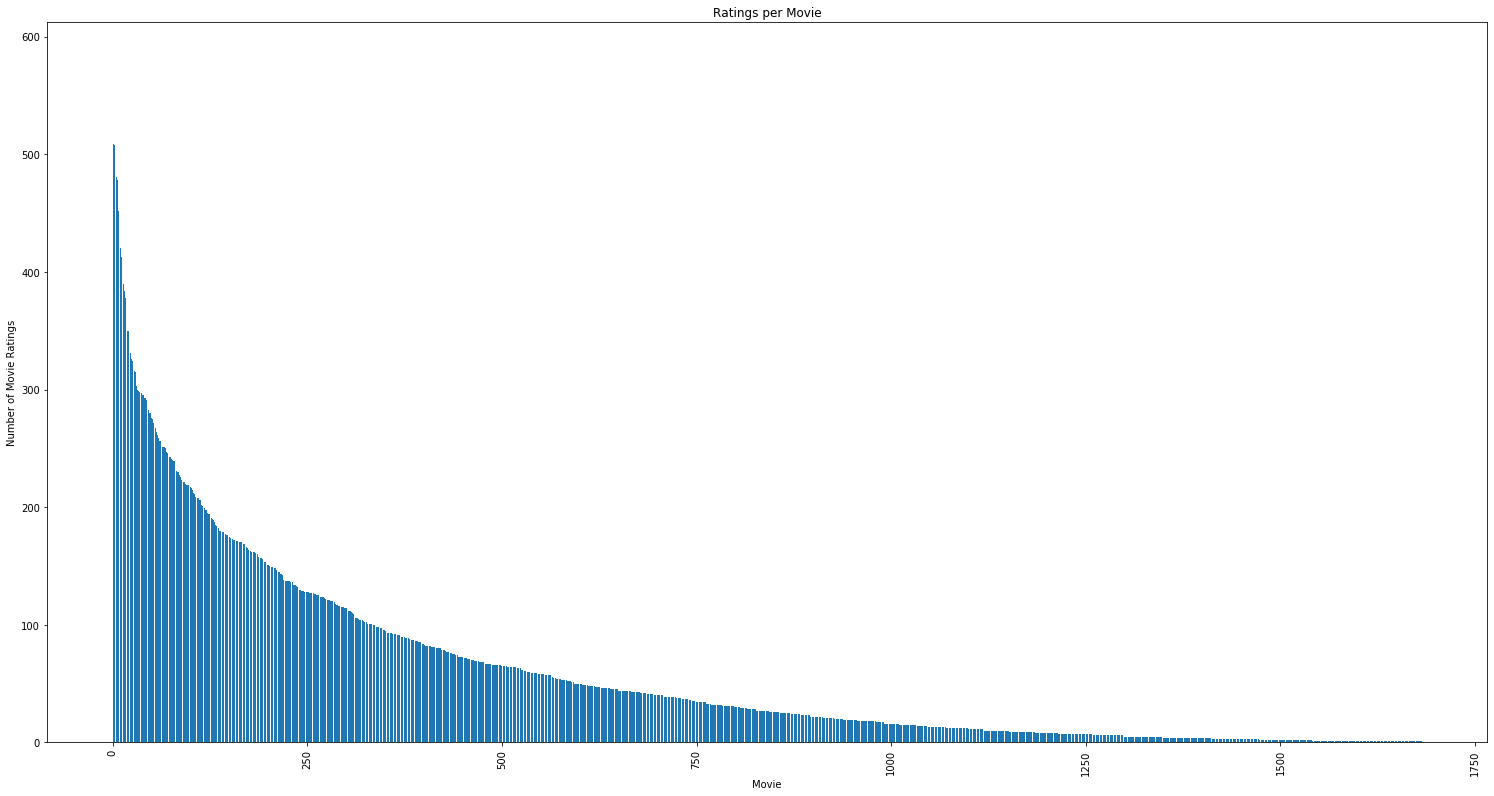

In [0]:
#Long Tail - Ratings per Movie
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(rpm['level_0'], rpm['count_ratings'])
plt.xticks(rotation=90)
plt.xlabel('Movie')
plt.ylabel('Number of Movie Ratings')
plt.title('Ratings per Movie')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [0]:
#Long Tail - Ratings per User
ratings_per_user=pd.DataFrame({'count_ratings' : ratings.groupby( "user_id").size()}).reset_index()
ratings_per_user.sort_values('count_ratings',ascending=False)

,user_id,count_ratings
404,404,737
654,654,685
12,12,636
449,449,540
275,275,518
...,...,...
684,684,20
474,474,20
35,35,20
731,731,20


In [0]:
rpu=ratings_per_user.sort_values('count_ratings',ascending=False)
rpu.reset_index(inplace = True) #Reset Movie Index (so movie with highest rating is indexed as '0')
rpu.reset_index(inplace = True) #Reset Movie Index (so movie with highest rating is indexed as '0')
rpu.head(20)

,level_0,index,user_id,count_ratings
0,0,404,404,737
1,1,654,654,685
2,2,12,12,636
3,3,449,449,540
4,4,275,275,518
5,5,415,415,493
6,6,536,536,490
7,7,302,302,484
8,8,233,233,480
9,9,392,392,448


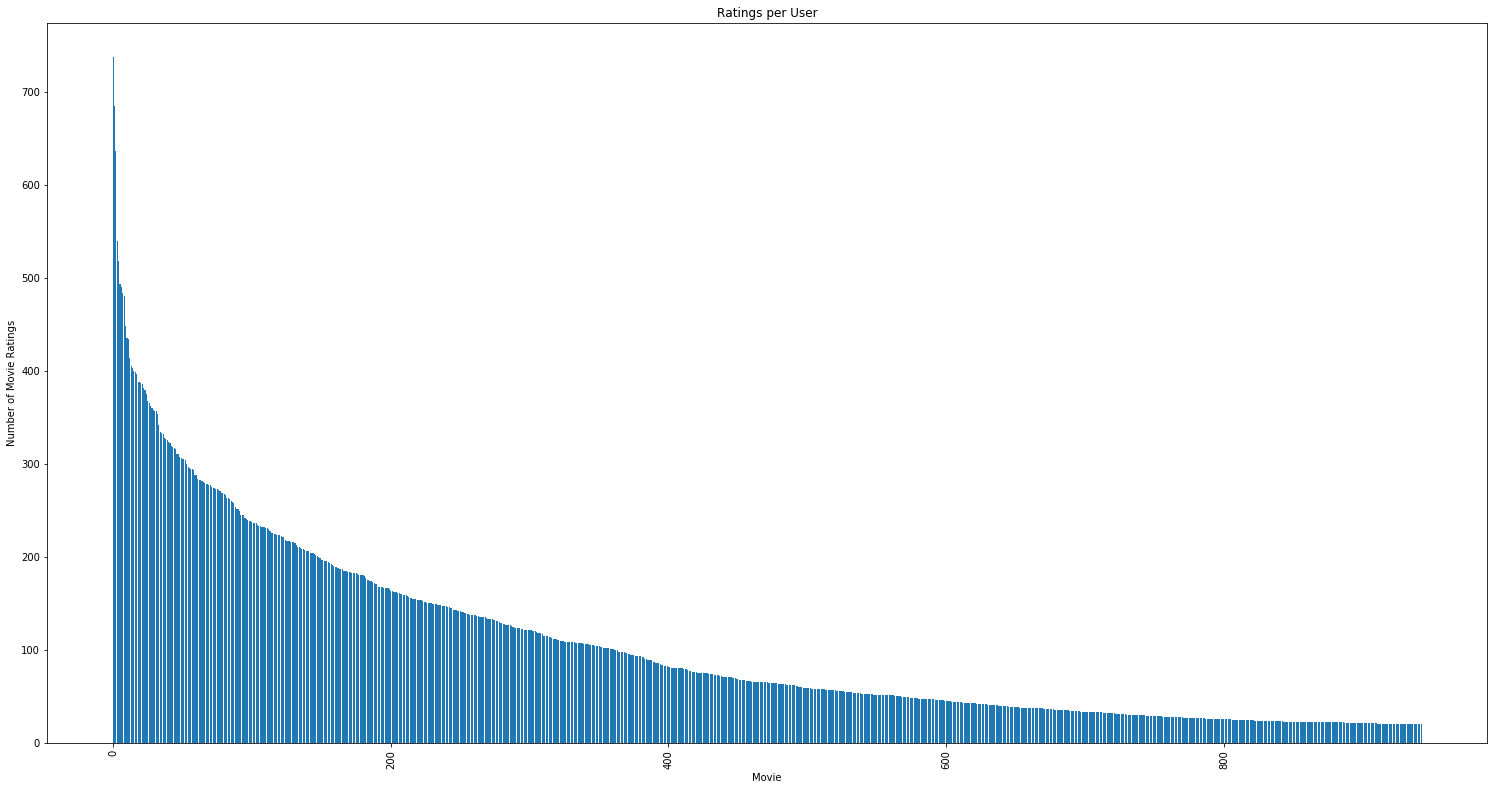

In [0]:
#Long Tail - Ratings per User
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(rpu['level_0'], rpu['count_ratings'])
plt.xticks(rotation=90)
plt.xlabel('Movie')
plt.ylabel('Number of Movie Ratings')
plt.title('Ratings per User')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [0]:
#Ratings Distribution (1) - Describe
ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

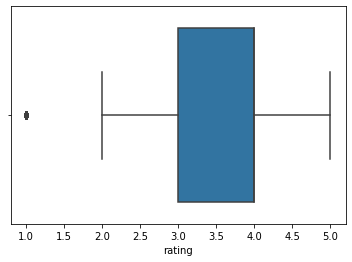

In [0]:
#Ratings Distribution (2) - BoxPlot
sns.boxplot(ratings['rating'])

array([3., 1., 2., 4., 5.])

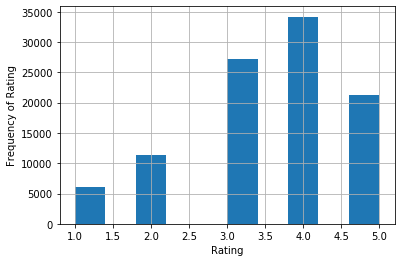

In [0]:
#Ratings Distribution (2) - Histogram
ratings['rating'].hist()
plt.xlabel('Rating'), plt.ylabel('Frequency of Rating')
ratings['rating'].unique()

### Extract the 'Valuable' Data


In [0]:
#Verification Each User has Rated at Least 20 Ratings (as given in Original DataSet)
user_rating_count = ratings.groupby("user_id").count()
user_rating_count = user_rating_count.sort_values("movie_id")
user_rating_count.head()
#user_rating_count.shape

,movie_id,rating,unix_timestamp
user_id,,,
201,20,20,20
440,20,20,20
684,20,20,20
33,20,20,20
35,20,20,20


In [0]:
#Counting Movie Ratings (+ Verification Each Movie in Dataset is Rated at least once)
movies_rating_count = ratings.groupby('movie_id').count()
movies_rating_count = movies_rating_count.sort_values('rating')
movies_rating_count.head()

,user_id,rating,unix_timestamp
movie_id,,,
1681,1,1,1
813,1,1,1
1446,1,1,1
1592,1,1,1
1451,1,1,1


In [0]:
############ USED FOR COLLABORATIVE FILTERING STATISTICS #########################
#Counting Movie Ratings by Movie Title
ratings_by_title=pd.merge(movies_unique,ratings,on='movie_id',sort=True)
ratings_by_title=ratings_by_title['title'].value_counts()
ratings_by_title=pd.DataFrame(ratings_by_title)
ratings_by_title=ratings_by_title.sort_values(by='title',ascending=False)
ratings_by_title

,title
Star Wars (1977),583
Contact (1997),509
Fargo (1996),508
Return of the Jedi (1983),507
Liar Liar (1997),485
...,...
"New Age, The (1994)",1
Hush (1998),1
Lashou shentan (1992),1
To Cross the Rubicon (1991),1


In [0]:
Total = ratings_by_title['title'].sum()
print (Total)

100000


In [0]:
#Calculating Minimum and Maximum Count of Movie Ratings
max_movie_rating=max(movies_rating_count['rating'])
min_movie_rating=min(movies_rating_count['rating'])
print(max_movie_rating,min_movie_rating )

583 1


In [0]:
movies_rating_count.tail()

,user_id,rating,unix_timestamp
movie_id,,,
293,485,485,485
180,507,507,507
99,508,508,508
257,509,509,509
49,583,583,583


In [0]:
movies_rating_count.sort_values('rating',ascending=False)

,user_id,rating,unix_timestamp
movie_id,,,
49,583,583,583
257,509,509,509
99,508,508,508
180,507,507,507
293,485,485,485
...,...,...,...
1342,1,1,1
1675,1,1,1
1674,1,1,1


In [0]:
ratings['movie_id']

0         241
1         301
2         376
3          50
4         345
         ... 
99995     475
99996     203
99997    1089
99998     224
99999     202
Name: movie_id, Length: 100000, dtype: int64

####Sensitivity Analysis - Total Number of Ratings Vs. Total Number of Movies

In [0]:
#Total Number of Ratings

tot_ratings=[]

#for i in list(range(min_movie_rating,max_movie_rating,round((max_movie_rating-min_movie_rating)/100))):
for i in list(range(min_movie_rating,max_movie_rating,5)):  
  tot_ratings.append(i)
tot_ratings=tot_ratings[::-1]
print (tot_ratings)

[581, 576, 571, 566, 561, 556, 551, 546, 541, 536, 531, 526, 521, 516, 511, 506, 501, 496, 491, 486, 481, 476, 471, 466, 461, 456, 451, 446, 441, 436, 431, 426, 421, 416, 411, 406, 401, 396, 391, 386, 381, 376, 371, 366, 361, 356, 351, 346, 341, 336, 331, 326, 321, 316, 311, 306, 301, 296, 291, 286, 281, 276, 271, 266, 261, 256, 251, 246, 241, 236, 231, 226, 221, 216, 211, 206, 201, 196, 191, 186, 181, 176, 171, 166, 161, 156, 151, 146, 141, 136, 131, 126, 121, 116, 111, 106, 101, 96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16, 11, 6, 1]


In [0]:
#Total Number of Movies
tot_movies=[]
for j in tot_ratings:
  movie_count = movies_rating_count[movies_rating_count['rating']>=j].count()
  #print(movie_count['rating'])
  tot_movies.append(movie_count['rating'])
print(tot_movies)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 11, 12, 12, 12, 12, 14, 15, 16, 17, 17, 18, 19, 19, 19, 21, 22, 23, 24, 25, 27, 29, 30, 30, 32, 38, 44, 45, 47, 51, 53, 56, 58, 62, 68, 71, 76, 81, 83, 88, 93, 102, 106, 114, 117, 122, 128, 132, 137, 148, 163, 173, 184, 193, 201, 213, 219, 232, 240, 261, 280, 294, 308, 316, 334, 350, 371, 393, 416, 436, 461, 499, 531, 566, 593, 639, 696, 743, 798, 858, 927, 1010, 1119, 1298, 1682]


In [0]:
#Movies with 5 Ratings and Above - the % of Overall Movies
movie_5 = movies_rating_count[movies_rating_count['rating']>=5].count()
movie_5
movie_5_per=movie_5/len(movies['movie_id'])
print(movie_5['rating'],movie_5_per['rating'])

1349 0.8020214030915577


In [0]:
#Ratings / Movies Frequency Table
freq_ratings_movies = pd.DataFrame({'Total Ratings':tot_ratings, 'Total Movies with These Ratings and Above':tot_movies,'Total Movies%':tot_movies/max(tot_movies)})
freq_ratings_movies.tail(10)

,Total Ratings,Total Movies with These Ratings and Above,Total Movies%
107,46,639,0.379905
108,41,696,0.413793
109,36,743,0.441736
110,31,798,0.474435
111,26,858,0.510107
112,21,927,0.551130
113,16,1010,0.600476
114,11,1119,0.665279
115,6,1298,0.771700
116,1,1682,1.000000


In [0]:
#Ratings / Movies Frequency Table
freq_ratings_movies = pd.DataFrame({'Total Ratings':tot_ratings, 'Total Movies with These Ratings and Above':tot_movies,'Total Movies%':tot_movies/max(tot_movies)})
freq_ratings_movies.head(10)

,Total Ratings,Total Movies with These Ratings and Above,Total Movies%
0,581,1,0.000595
1,576,1,0.000595
2,571,1,0.000595
3,566,1,0.000595
4,561,1,0.000595
5,556,1,0.000595
6,551,1,0.000595
7,546,1,0.000595
8,541,1,0.000595
9,536,1,0.000595


In [0]:
#Plot - Total Ratings Vs. Total Movies
#Createing Dataset for Graph
plot_df=freq_ratings_movies.drop(['Total Movies%'], axis = 1)
plot_df

,Total Ratings,Total Movies with These Ratings and Above
0,581,1
1,576,1
2,571,1
3,566,1
4,561,1
...,...,...
112,21,927
113,16,1010
114,11,1119
115,6,1298


In [0]:
#'Describe' for the Rating Count Each Movie Recieved
plot_df['Total Movies with These Ratings and Above'].describe()

count     117.000000
mean      177.179487
std       295.267635
min         1.000000
25%         8.000000
50%        44.000000
75%       213.000000
max      1682.000000
Name: Total Movies with These Ratings and Above, dtype: float64

In [0]:
#Movies-Users-Ratings Filtered Dataset (to movies which have 5 ratings and above)
Movies_Users_Ratings_Filtered = pd.DataFrame(movies_rating_count[movies_rating_count['rating']>=5])
Movies_Users_Ratings_Filtered.info()
MoviesToKeep=Movies_Users_Ratings_Filtered.index.tolist()
MoviesToKeep[1:10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1349 entries, 1174 to 49
Data columns (total 3 columns):
user_id           1349 non-null int64
rating            1349 non-null int64
unix_timestamp    1349 non-null int64
dtypes: int64(3)
memory usage: 42.2 KB


[1377, 1469, 74, 1332, 1241, 798, 246, 1415, 1366]

In [0]:
#Verification #1 - All Unique Filtered Movies Are Included in 'MoviesToKeep'
UniqueFilteredMovies=np.unique(MoviesToKeep)
UniqueFilteredMovies
print (len(UniqueFilteredMovies)) 

1349


In [0]:
#Verification #2 - All 'MoviesToKeep' Have at Least 5 Ratings
filtered_ratings = ratings[ratings['movie_id'].isin(MoviesToKeep)]
filtered_ratings.groupby('movie_id').count().sort_values('rating')

,user_id,rating,unix_timestamp
movie_id,,,
1396,5,5,5
1137,5,5,5
1323,5,5,5
438,5,5,5
1332,5,5,5
...,...,...,...
293,485,485,485
180,507,507,507
99,508,508,508


In [0]:
# Verification #3 - % of movies remained after filtering
len(filtered_ratings['movie_id'].unique())/len(ratings['movie_id'].unique())

0.8020214030915577

In [0]:
# % of users remained after filtering
len(filtered_ratings['user_id'].unique())/len(ratings['user_id'].unique())

1.0

In [0]:
# % of Rating (Entries) remained after filtering
len(filtered_ratings['rating'])/(len(ratings['rating']))

0.99287

### 'Valuable' Datasets Manipulation

In [0]:
#Summary - modifications to original 'movies' dataset (no need to run)
#movies=movies_bu #movies_bu=copy of dataset
#movies['movie_id'] = pd.to_numeric(movies['movie_id'])
#movies = movies.drop('imdb_url', axis =1)
#movies

In [0]:
movies['video_release_date'] = movies['release_date'] # Copy 'release date' column to 'video release date' column

In [0]:
movies_bu = movies.copy()

In [0]:
movies = movies_bu.copy()
movies.head(10)

In [11]:
# Extracting year from 'movie title'
def split_year(string):
    x = re.split("[()]", string)
    return x[len(x)-2]

# Extracting movie title from 'movie title'
def split_moviename(string):
    x = re.split("[()]", string)
    return x[0]

movies["release_date"] = movies["title"].apply(split_year) # apply year extraction on 'movie title' column
#movies["title"] = movies["title"].apply(split_moviename) # apply movie name extraction on 'movie title' column
#movies['title'] = movies['title'] +' (' + movies['release_date'] + ')'
movies.head(10)

,movie_id,title,release_date,video_release_date,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),1995,NaN,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Animation Children Comedy
1,1,GoldenEye (1995),1995,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Adventure,Action Adventure Thriller
2,2,Four Rooms (1995),1995,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),1995,NaN,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Action,Action Comedy Drama
4,4,Copycat (1995),1995,NaN,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,Drama,Crime Drama Thriller
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Drama,Drama
6,6,Twelve Monkeys (1995),1995,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1995,Drama,Drama Sci-Fi
7,7,Babe (1995),1995,NaN,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Children Comedy Drama
8,8,Dead Man Walking (1995),1995,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Drama,Drama
9,9,Richard III (1995),1995,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1996,Drama,Drama War


### Meta Dataset Creation of 'Valuable' Data


In [0]:
movies_filtered = movies.drop(['release_date','video_release_date','genre'], axis = 1)
movies_filtered = movies_filtered.drop(movies_filtered.loc[:,'genre_unknown':'Western'], axis = 1)
movies_filtered = movies_filtered[movies_filtered['movie_id'].isin(MoviesToKeep)]
movies_filtered.tail()
movies_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1349 entries, 0 to 1619
Data columns (total 4 columns):
movie_id      1349 non-null int64
title         1349 non-null object
year          1349 non-null object
all_genres    1349 non-null object
dtypes: int64(1), object(3)
memory usage: 52.7+ KB


In [0]:
Filtered_Meta_Dataset = pd.merge(movies_filtered, filtered_ratings, on = 'movie_id', how ='left', sort = True)
Filtered_Meta_Dataset.tail(10) 

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
99277,1614,Warriors of Virtue (1997),1997,Action Adventure Children Fantasy,851,2.0,1998-03-27 22:07:37
99278,1619,"Sixth Man, The (1997)",1997,Comedy,551,3.0,1997-11-11 04:21:11
99279,1619,"Sixth Man, The (1997)",1997,Comedy,652,2.0,1998-01-29 05:38:11
99280,1619,"Sixth Man, The (1997)",1997,Comedy,549,4.0,1997-12-29 19:57:28
99281,1619,"Sixth Man, The (1997)",1997,Comedy,643,4.0,1998-03-05 05:54:07
99282,1619,"Sixth Man, The (1997)",1997,Comedy,673,4.0,1998-02-18 00:50:35
99283,1619,"Sixth Man, The (1997)",1997,Comedy,900,5.0,1997-10-17 22:19:03
99284,1619,"Sixth Man, The (1997)",1997,Comedy,781,3.0,1998-04-02 06:44:00
99285,1619,"Sixth Man, The (1997)",1997,Comedy,879,3.0,1997-11-22 02:54:48
99286,1619,"Sixth Man, The (1997)",1997,Comedy,591,1.0,1997-12-20 09:10:57


In [0]:
Filtered_Meta_Dataset.head(10) 

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44
5,0,Toy Story (1995),1995,Animation Children Comedy,4,4.0,1997-09-30 16:09:08
6,0,Toy Story (1995),1995,Animation Children Comedy,108,4.0,1997-11-26 17:00:19
7,0,Toy Story (1995),1995,Animation Children Comedy,180,3.0,1997-11-08 04:13:12
8,0,Toy Story (1995),1995,Animation Children Comedy,94,5.0,1997-11-10 21:28:49
9,0,Toy Story (1995),1995,Animation Children Comedy,267,3.0,1997-10-01 21:45:41


In [0]:
Filtered_Meta_Dataset.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99287 entries, 0 to 99286
Data columns (total 7 columns):
movie_id          99287 non-null int64
title             99287 non-null object
year              99287 non-null object
all_genres        99287 non-null object
user_id           99287 non-null int64
rating            99287 non-null float64
unix_timestamp    99287 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


## Exploratory 'Valuable' Data Analysis

###Movies


####Distinct Movies from 'Filtered_Meta_Dataset'



In [0]:
Filtered_Movies_Dataset=Filtered_Meta_Dataset.drop(['user_id','rating'], axis = 1)
Filtered_Movies_Dataset=Filtered_Movies_Dataset.drop_duplicates()
Filtered_Movies_Dataset.head(10)

,movie_id,title,year,all_genres,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,1997-12-31 20:48:44
5,0,Toy Story (1995),1995,Animation Children Comedy,1997-09-30 16:09:08
6,0,Toy Story (1995),1995,Animation Children Comedy,1997-11-26 17:00:19
7,0,Toy Story (1995),1995,Animation Children Comedy,1997-11-08 04:13:12
8,0,Toy Story (1995),1995,Animation Children Comedy,1997-11-10 21:28:49
9,0,Toy Story (1995),1995,Animation Children Comedy,1997-10-01 21:45:41


In [0]:
Filtered_Movies_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99287 entries, 0 to 99286
Data columns (total 5 columns):
movie_id          99287 non-null int64
title             99287 non-null object
year              99287 non-null object
all_genres        99287 non-null object
unix_timestamp    99287 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.5+ MB


####Movies by Year

In [0]:
#Movies by Year from 'Filtered_Meta_Dataset'
movies_flt_by_year=pd.DataFrame({'count' : Filtered_Movies_Dataset.groupby('year').size()}).reset_index()
movies_flt_by_year.sort_values('year')

,year,count
0,1922,54
1,1930,18
2,1931,44
3,1932,12
4,1933,93
...,...,...
66,1995,10415
67,1996,19556
68,1997,17253
69,1998,933


In [0]:
#Movies by Year from 'Filtered_Meta_Dataset'
movies_flt_by_year=pd.DataFrame({'count' : Filtered_Movies_Dataset.groupby('year').size()}).reset_index()
movies_flt_by_year.sort_values('count')

,year,count
70,nan,9
3,1932,12
1,1930,18
14,1943,20
7,1936,39
...,...,...
64,1993,6598
65,1994,8781
66,1995,10415
68,1997,17253


In [0]:
movies_flt_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
year     71 non-null object
count    71 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


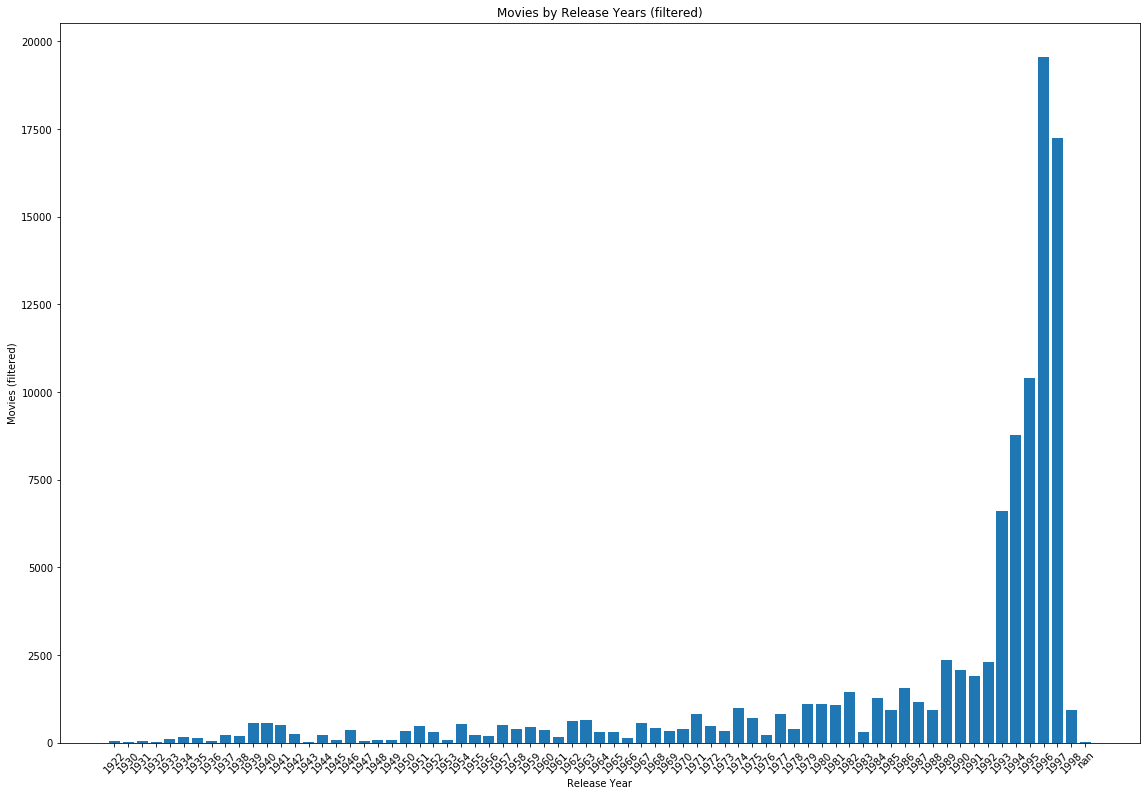

In [0]:
#Movies by Year Plot from 'Filtered_Meta_Dataset'
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(movies_flt_by_year['year'],movies_flt_by_year['count'])
plt.xticks(rotation=45)
plt.xlabel('Release Year')
plt.ylabel('Movies (filtered)')
plt.title('Movies by Release Years (filtered)')
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

In [0]:
#Movies by Year from 'Movies' Dataset
movies_by_year=pd.DataFrame({'count' : movies.groupby('year').size()}).reset_index()
movies_by_year.sort_values('year')

,year,count
0,1922,1
1,1926,1
2,1930,1
3,1931,1
4,1932,1
...,...,...
67,1995,219
68,1996,355
69,1997,286
70,1998,65


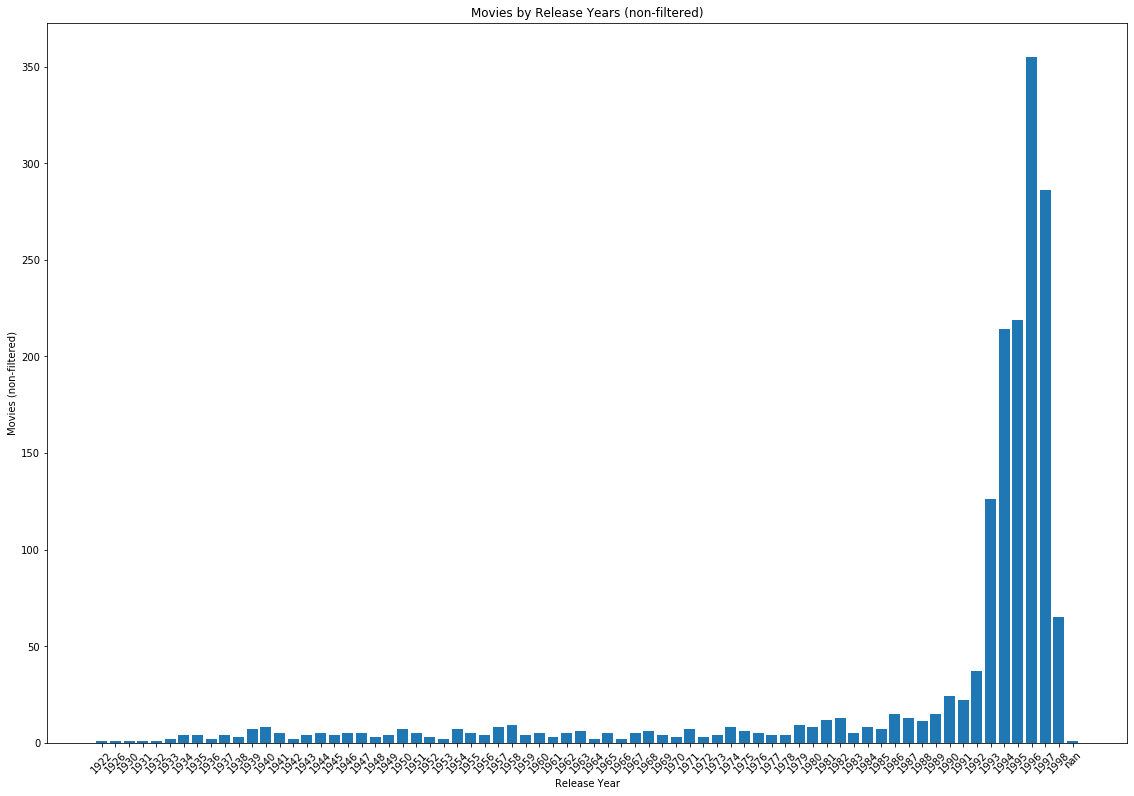

In [0]:
#Movies by Year Plot from 'Movies' Datase
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(movies_by_year['year'],movies_by_year['count'])
plt.xticks(rotation=45)
plt.xlabel('Release Year')
plt.ylabel('Movies (non-filtered)')
plt.title('Movies by Release Years (non-filtered)')
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

####Movies by 'all-genre'

In [0]:
#Movies by 'all-genre' from 'Filtered_Meta_Dataset'
movies_flt_by_genres=pd.DataFrame({'count' : Filtered_Movies_Dataset.groupby( 'all_genres').size()}).reset_index()
movies_flt_by_genres.sort_values('count',ascending=False)

,all_genres,count
163,Drama,12989
119,Comedy,9733
139,Comedy Romance,5033
172,Drama Romance,4748
72,Action Thriller,3547
...,...,...
5,Action Adventure Children Fantasy,10
181,Drama Western,9
211,genre_unknown,9
4,Action Adventure Children,5


In [0]:
movies_flt_by_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 2 columns):
all_genres    212 non-null object
count         212 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


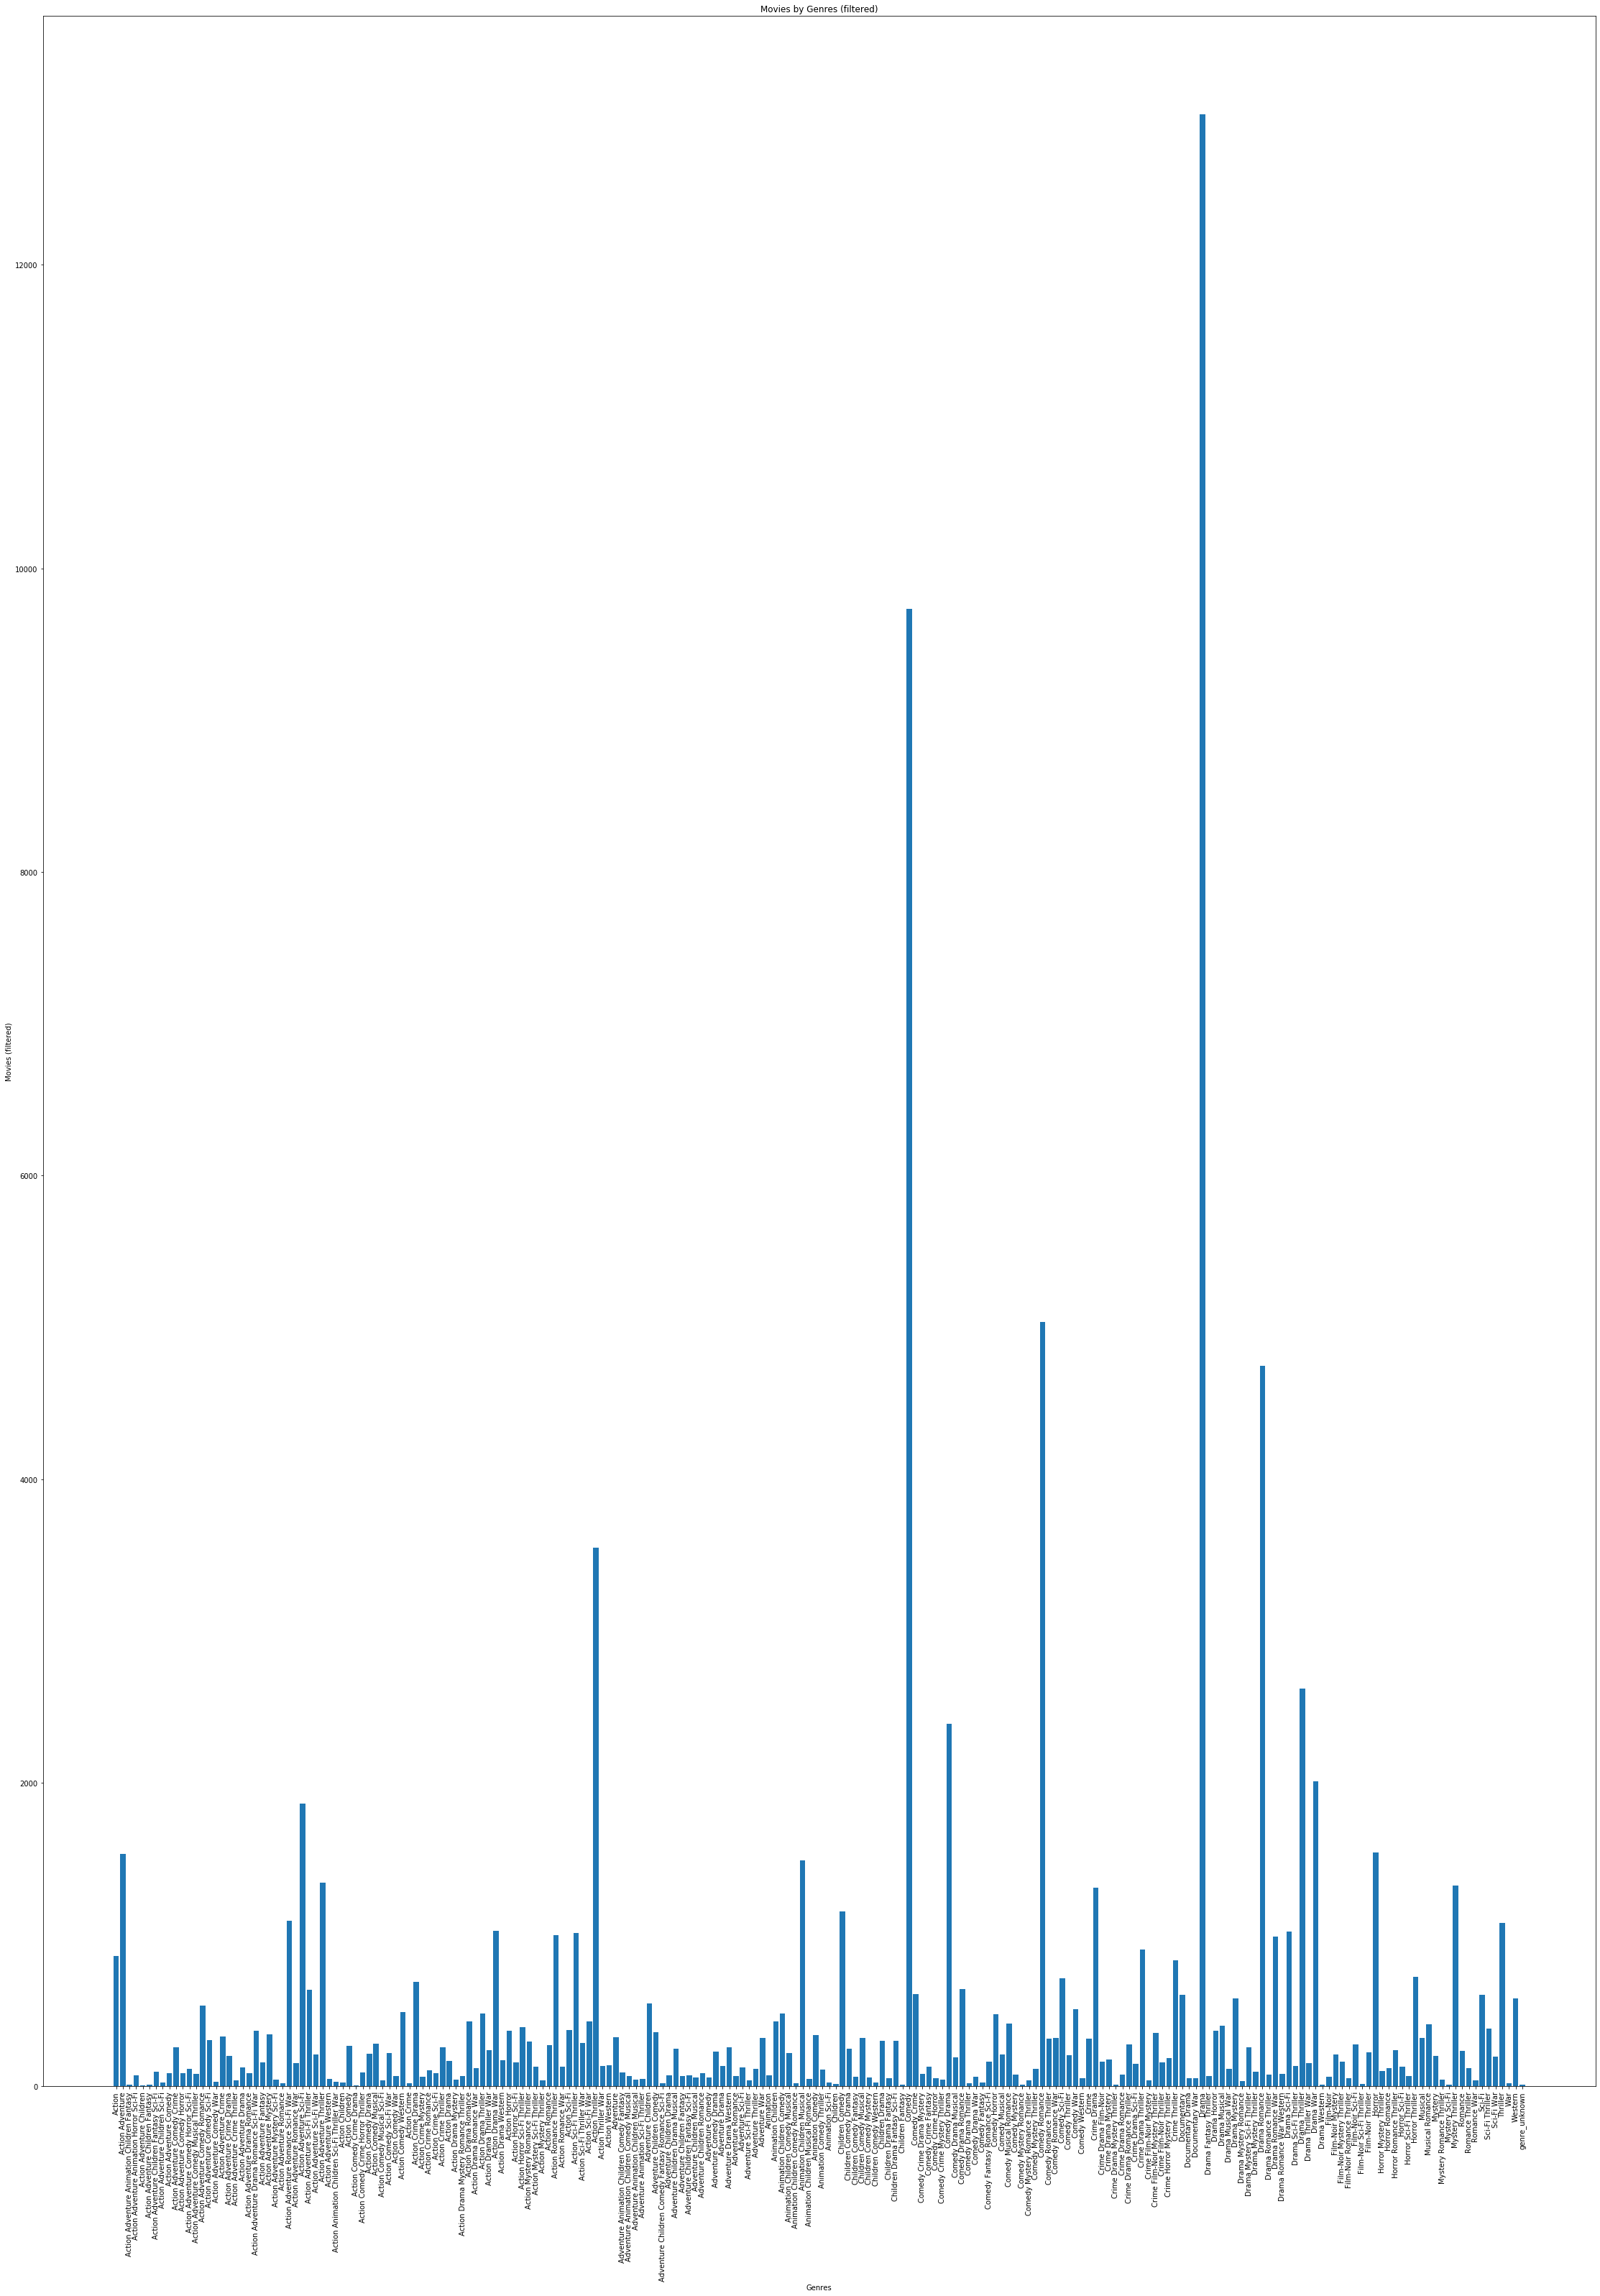

In [0]:
#Movies by 'all-genre' Plot from 'Filtered_Meta_Dataset'
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(movies_flt_by_genres['all_genres'],movies_flt_by_genres['count'])
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Movies (filtered)')
plt.title('Movies by Genres (filtered)')
fig=plt.gcf()
fig.set_size_inches(30,40)
plt.show()

In [0]:
#Movies by 'all-genre' from 'movies' dataset
movies_by_genres=pd.DataFrame({'count' : movies.groupby( 'all_genres').size()}).reset_index()
movies_by_genres.sort_values('count', ascending=False)

,all_genres,count
166,Drama,376
119,Comedy,210
141,Comedy Romance,68
175,Drama Romance,67
127,Comedy Drama,65
...,...,...
41,Action Comedy Sci-Fi War,1
143,Comedy Romance War,1
42,Action Comedy War,1
96,Adventure Thriller,1


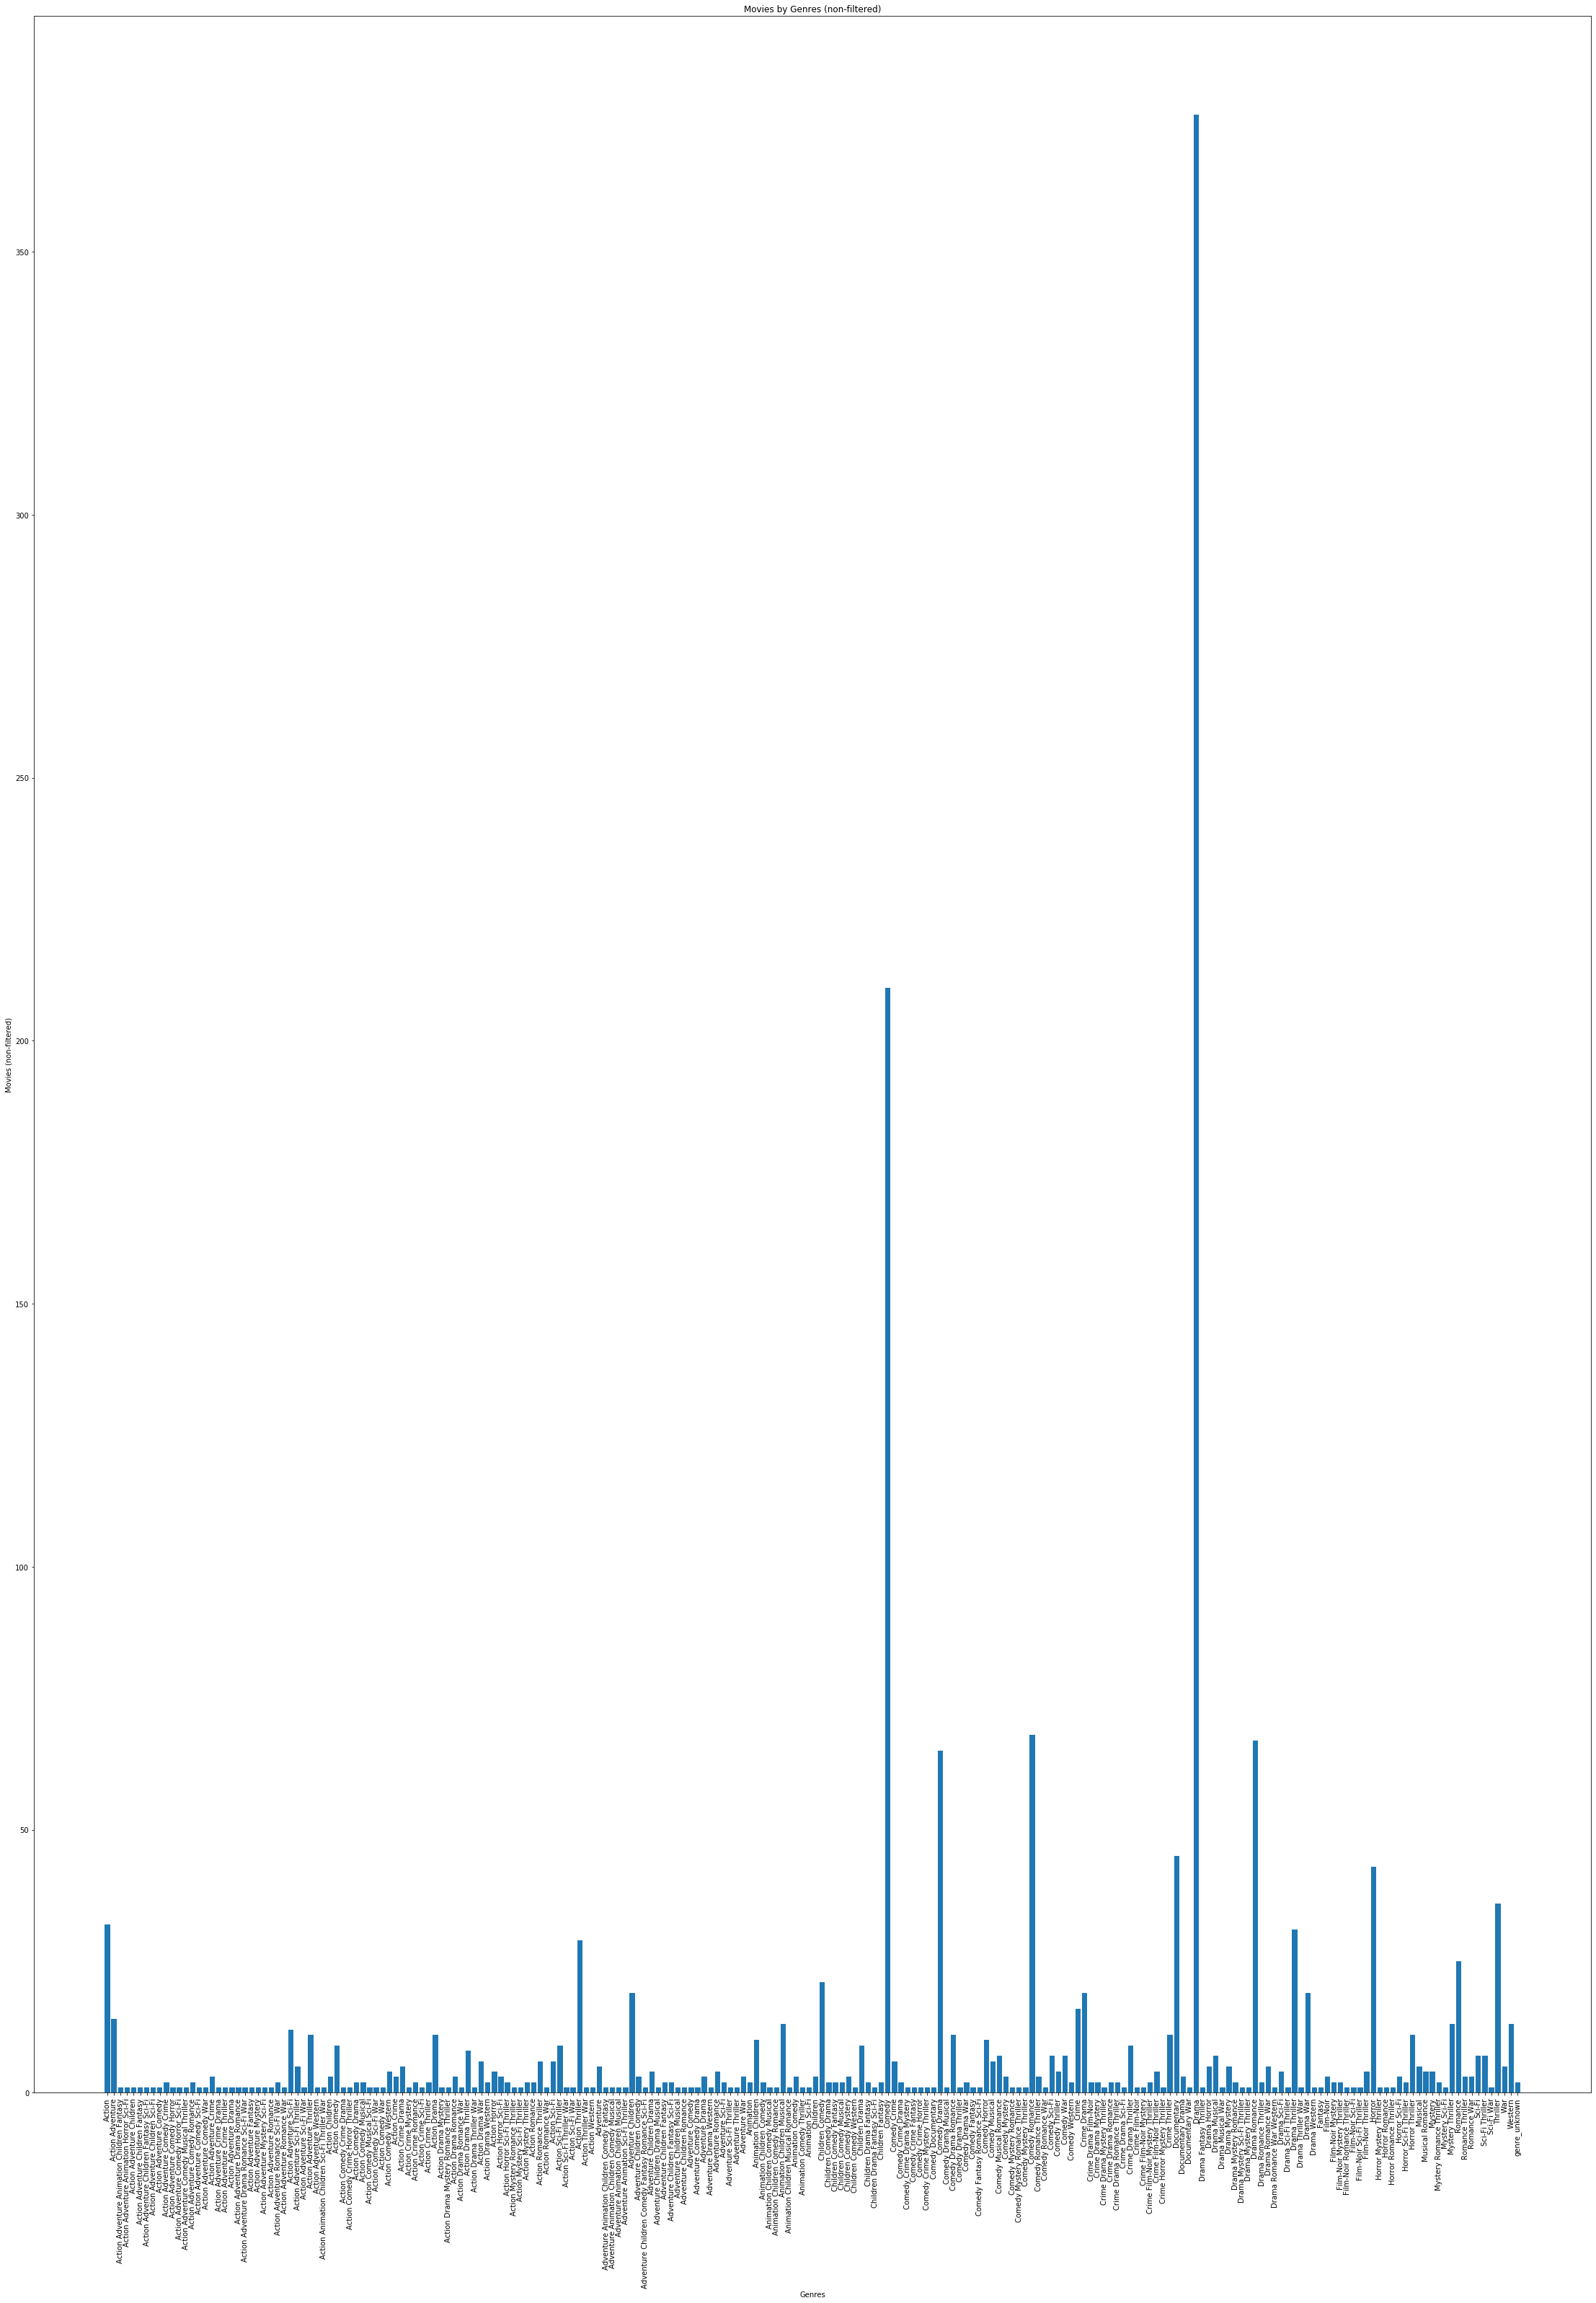

In [0]:
#Movies by 'all-genre' Plot from 'movies' dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(movies_by_genres['all_genres'],movies_by_genres['count'])
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Movies (non-filtered)')
plt.title('Movies by Genres (non-filtered)')
fig=plt.gcf()
fig.set_size_inches(30,40)
plt.show()

###Users

####Users by Age

In [0]:
#Users by Age
users_by_age=pd.DataFrame({'count' : users.groupby( 'age').size()}).reset_index()
users_by_age.sort_values('count',ascending=False)

,age,count
20,30,39
15,25,38
12,22,37
18,28,36
17,27,35
...,...,...
0,7,1
56,66,1
1,10,1
2,11,1


In [0]:
users_by_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
age      61 non-null int64
count    61 non-null int64
dtypes: int64(2)
memory usage: 1.1 KB


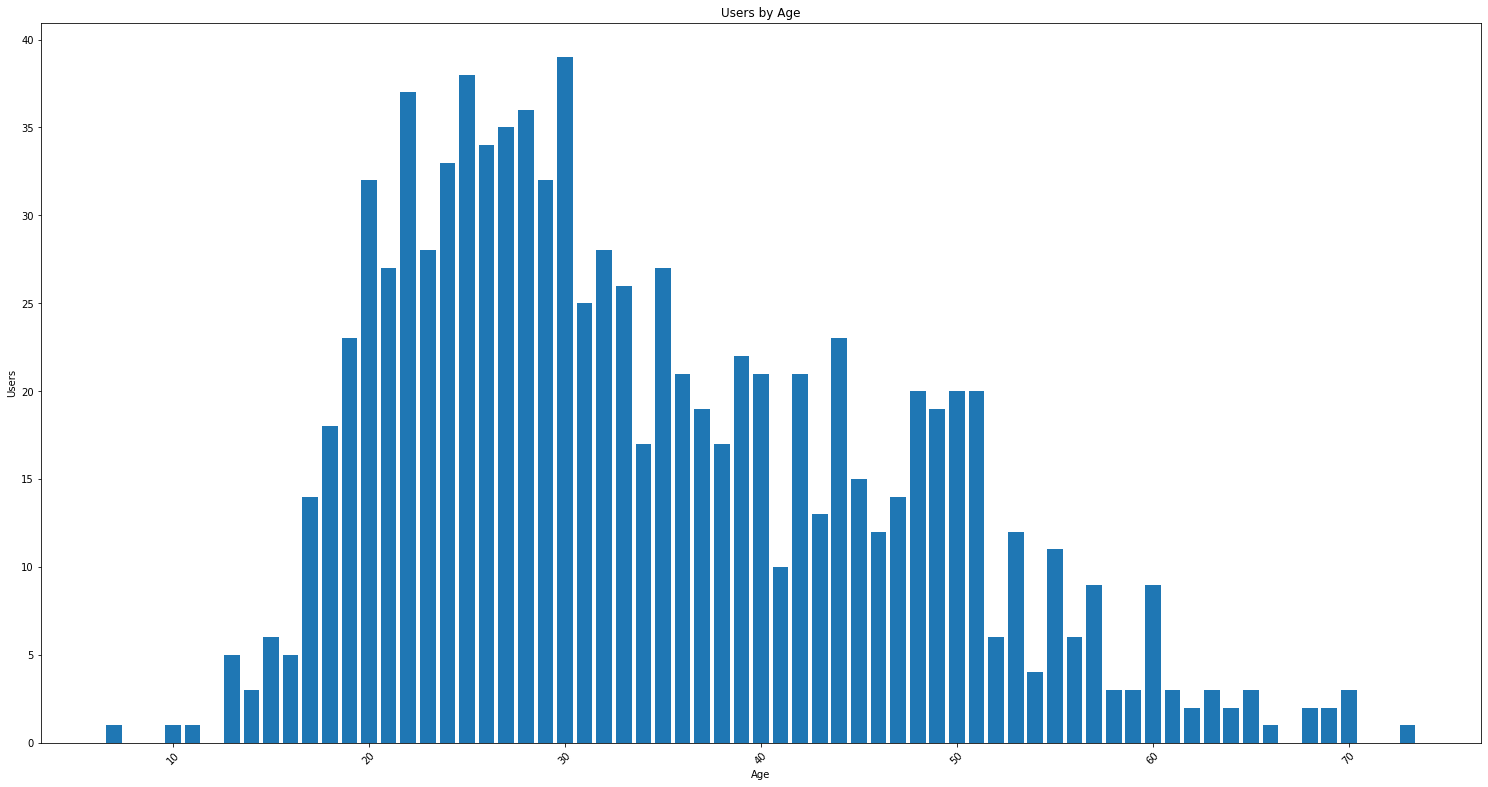

In [0]:
#Users by Age Plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(users_by_age['age'],users_by_age['count'])
plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Users')
plt.title('Users by Age')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

####Users by Gender

In [0]:
#Users by Gender
users_by_gender=pd.DataFrame({'count' : users.groupby( 'gender').size()}).reset_index()
users_by_gender.sort_values('count')

,gender,count
0,F,273
1,M,670


####Users by Occupation

In [0]:
#Users by Gender
users_by_occupation=pd.DataFrame({'count' : users.groupby( 'occupation').size()}).reset_index()
users_by_occupation.sort_values('count',ascending=False)

,occupation,count
18,student,196
13,other,105
3,educator,95
0,administrator,79
4,engineer,67
14,programmer,66
10,librarian,51
20,writer,45
6,executive,32
17,scientist,31


In [0]:
users_by_occupation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
occupation    21 non-null object
count         21 non-null int64
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


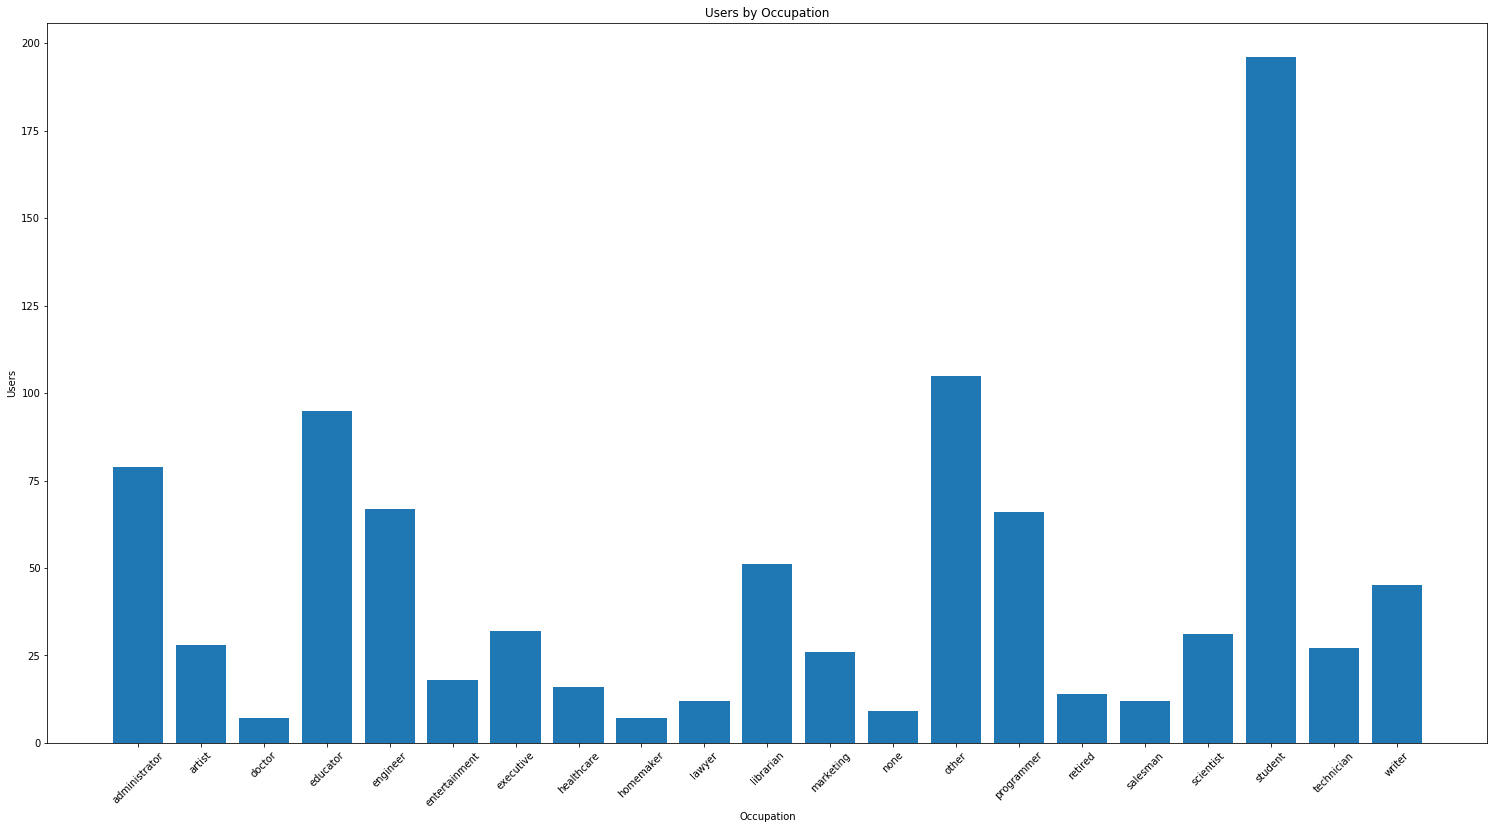

In [0]:
#Users by Occupation Plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(users_by_occupation['occupation'],users_by_occupation['count'])
plt.xticks(rotation=45)
plt.xlabel('Occupation')
plt.ylabel('Users')
plt.title('Users by Occupation')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

###Ratings


####Ratings Counts per User


In [0]:
#Ratings Histogram / Data from 'Filtered_Meta_Dataset'
ratings_flt_histogram=pd.DataFrame({'count' : Filtered_Meta_Dataset.groupby( 'rating').size()}).reset_index()
ratings_flt_histogram

,rating,count
0,1.0,5900
1,2.0,11259
2,3.0,26963
3,4.0,34035
4,5.0,21130


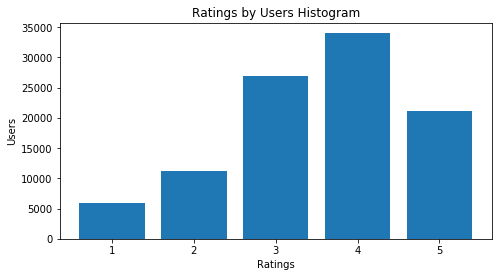

In [0]:
#Rating Histogram Plot from 'Filtered_Meta_Dataset'
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ratings_flt_histogram['rating'], ratings_flt_histogram['count'])
plt.xlabel('Ratings')
plt.ylabel('Users')
plt.title('Ratings by Users Histogram')
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.show()

####Rating Counts per Genre

In [0]:
# Rating Counts per genre from 'Filtered_Meta_Dataset'
ratings_flt_per_genre=pd.DataFrame({'count' : Filtered_Meta_Dataset.groupby( "all_genres").size()}).reset_index()
ratings_flt_per_genre.sort_values('count',ascending=False)

,all_genres,count
163,Drama,12989
119,Comedy,9733
139,Comedy Romance,5033
172,Drama Romance,4748
72,Action Thriller,3547
...,...,...
5,Action Adventure Children Fantasy,10
181,Drama Western,9
211,genre_unknown,9
4,Action Adventure Children,5


In [0]:
ratings_flt_per_genre.sort_values('count',ascending=False).head(10)

,all_genres,count
163,Drama,12989
119,Comedy,9733
139,Comedy Romance,5033
172,Drama Romance,4748
72,Action Thriller,3547
178,Drama Thriller,2619
125,Comedy Drama,2389
180,Drama War,2007
28,Action Adventure Sci-Fi,1863
189,Horror,1541


In [0]:
ratings_flt_per_genre.tail(10)

,all_genres,count
202,Romance,234
203,Romance Thriller,119
204,Romance War,40
205,Sci-Fi,605
206,Sci-Fi Thriller,382
207,Sci-Fi War,194
208,Thriller,1076
209,War,22
210,Western,578
211,genre_unknown,9


In [0]:
#Average Rating (Grade) per genre
ratings_flt_per_genre=pd.DataFrame({'Mean' : Filtered_Meta_Dataset.groupby( "all_genres").mean()['rating']}).reset_index()
ratings_flt_per_genre.sort_values('Mean',ascending=False)

,all_genres,Mean
106,Animation Comedy Thriller,4.491071
98,Animation,4.430556
207,Sci-Fi War,4.252577
21,Action Adventure Drama Romance Sci-Fi War,4.204360
182,Film-Noir,4.200000
...,...,...
118,Children Fantasy,2.166667
83,Adventure Children Drama,2.140845
34,Action Children,2.080000
7,Action Adventure Children Sci-Fi,2.076923


In [0]:
Filtered_Meta_Dataset['rating'].describe()

count    99287.000000
mean         3.536183
std          1.121462
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [0]:
ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

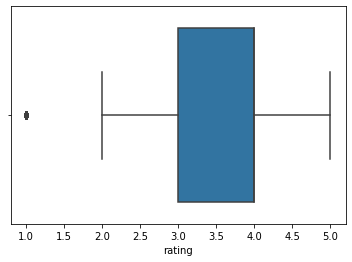

In [0]:
sns.boxplot(Filtered_Meta_Dataset['rating'])

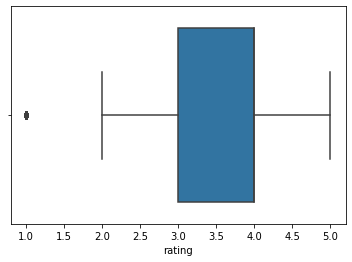

In [0]:
sns.boxplot(ratings['rating'])

## Model Evaluation

### The Datasets

In [13]:
#Meta_Dataset
#Movies for Meta_Data
movies_metadata=movies.drop(['release_date','video_release_date','genre'],axis=1)
movies_metadata=movies_metadata.drop(movies_metadata.loc[:,'genre_unknown':'Western'],axis=1)
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 4 columns):
movie_id      1682 non-null int64
title         1682 non-null object
year          1682 non-null object
all_genres    1682 non-null object
dtypes: int64(1), object(3)
memory usage: 52.7+ KB


In [14]:
movies_metadata.head(10) #***Take this and addd additional information (Directors,Crew,Composer etc.)***

,movie_id,title,year,all_genres
0,0,Toy Story (1995),1995,Animation Children Comedy
1,1,GoldenEye (1995),1995,Action Adventure Thriller
2,2,Four Rooms (1995),1995,Thriller
3,3,Get Shorty (1995),1995,Action Comedy Drama
4,4,Copycat (1995),1995,Crime Drama Thriller
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995,Drama
6,6,Twelve Monkeys (1995),1995,Drama Sci-Fi
7,7,Babe (1995),1995,Children Comedy Drama
8,8,Dead Man Walking (1995),1995,Drama
9,9,Richard III (1995),1996,Drama War


In [0]:
Meta_Dataset=pd.merge(movies_metadata,ratings, on='movie_id',how='left',sort=True)
Meta_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
movie_id          100000 non-null int64
title             100000 non-null object
year              100000 non-null object
all_genres        100000 non-null object
user_id           100000 non-null int64
rating            100000 non-null float64
unix_timestamp    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [0]:
Meta_Dataset.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#Specific User Preferences
spec_user=Meta_Dataset.loc[Meta_Dataset['user_id']==286,:]
spec_user_sort=spec_user.sort_values(['rating'], ascending=[False])
spec_user_sort.iloc[0:15,]

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
23442,167,Monty Python and the Holy Grail (1974),1974,Comedy,286,5.0,1997-09-27 04:39:50
87133,844,That Thing You Do! (1996),1996,Comedy,286,5.0,1997-09-27 04:29:47
72705,590,Primal Fear (1996),1996,Drama Thriller,286,5.0,1997-09-27 04:24:53
61664,460,Smoke (1995),1995,Drama,286,5.0,1997-09-27 05:04:12
52724,345,Jackie Brown (1997),1997,Crime Drama,286,5.0,1998-02-22 19:50:40
52249,339,Boogie Nights (1997),1997,Drama,286,5.0,1998-02-22 19:51:37
50872,326,Cop Land (1997),1997,Crime Drama Mystery,286,5.0,1997-09-27 04:18:36
45752,293,Liar Liar (1997),1997,Comedy,286,5.0,1997-09-27 04:17:53
45381,290,Absolute Power (1997),1997,Mystery Thriller,286,5.0,1998-02-22 19:56:42


In [0]:
#Dataset #1 - Movies with 1 Rating and Above (All Data)
#Movies-Users-Ratings Filtered Dataset (to movies which have 1 rating and above)
Movies_Users_Ratings_Filtered = pd.DataFrame(movies_rating_count[movies_rating_count['rating']>=1])
Movies_Users_Ratings_Filtered.info()
MoviesToKeep1=Movies_Users_Ratings_Filtered.index.tolist()
MoviesToKeep1[1:10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1681 to 49
Data columns (total 3 columns):
user_id           1682 non-null int64
rating            1682 non-null int64
unix_timestamp    1682 non-null int64
dtypes: int64(3)
memory usage: 52.6 KB


[813, 1446, 1592, 1451, 1452, 1456, 1457, 1459, 1460]

In [0]:
#Dataset #1 - Filtered Dataset Creation
movies_filtered_1=Meta_Dataset[Meta_Dataset['movie_id'].isin(MoviesToKeep1)]
movies_filtered_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
movie_id          100000 non-null int64
title             100000 non-null object
year              100000 non-null object
all_genres        100000 non-null object
user_id           100000 non-null int64
rating            100000 non-null float64
unix_timestamp    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [0]:
movies_filtered_1.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#FilteredRatings1
filtered_ratings1 = ratings[ratings['movie_id'].isin(MoviesToKeep1)]

In [0]:
#Dataset #1 Verification (Movies) - % of Movies to Keep After Filtering
len(filtered_ratings1['movie_id'].unique())/len(ratings['movie_id'].unique())

1.0

In [0]:
#Data #1 -  Verification (Users) - % of Users Remained After Filtering
len(filtered_ratings1['user_id'].unique())/len(ratings['user_id'].unique())

1.0

In [0]:
#Data #1 -  Verification (Rating Entries) - % of Rating (Entries) Remained After Filtering
len(filtered_ratings1['rating'])/len(ratings['rating'])

1.0

In [0]:
#Dataset #2 - Movies with 5 Ratings and Above
#Movies-Users-Ratings Filtered Dataset (to movies which have 5 ratings and above)
Movies_Users_Ratings_Filtered = pd.DataFrame(movies_rating_count[movies_rating_count['rating']>=5])
Movies_Users_Ratings_Filtered.info()
MoviesToKeep5=Movies_Users_Ratings_Filtered.index.tolist()
MoviesToKeep5[1:10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1349 entries, 1174 to 49
Data columns (total 3 columns):
user_id           1349 non-null int64
rating            1349 non-null int64
unix_timestamp    1349 non-null int64
dtypes: int64(3)
memory usage: 42.2 KB


[1377, 1469, 74, 1332, 1241, 798, 246, 1415, 1366]

In [0]:
#Dataset #2 - Filtered Dataset Creation
movies_filtered_5=Meta_Dataset[Meta_Dataset['movie_id'].isin(MoviesToKeep5)]
movies_filtered_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99287 entries, 0 to 99910
Data columns (total 7 columns):
movie_id          99287 non-null int64
title             99287 non-null object
year              99287 non-null object
all_genres        99287 non-null object
user_id           99287 non-null int64
rating            99287 non-null float64
unix_timestamp    99287 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [0]:
movies_filtered_5.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#FilteredRatings5
filtered_ratings5 = ratings[ratings['movie_id'].isin(MoviesToKeep5)]

In [0]:
#Dataset #2 Verification (Movies) - % of Movies to Keep After Filtering
len(filtered_ratings5['movie_id'].unique())/len(ratings['movie_id'].unique())

0.8020214030915577

In [0]:
#Data #2 -  Verification (Users) - % of Users Remained After Filtering
len(filtered_ratings5['user_id'].unique())/len(ratings['user_id'].unique())

1.0

In [0]:
#Data #2 -  Verification (Rating Entries) - % of Rating (Entries) Remained After Filtering
len(filtered_ratings5['rating'])/len(ratings['rating'])

0.99287

In [0]:
#Dataset #3- Movies with 20 Ratings and Above
#Movies-Users-Ratings Filtered Dataset (to movies which have 20 ratings and above)
Movies_Users_Ratings_Filtered = pd.DataFrame(movies_rating_count[movies_rating_count['rating']>=20])
Movies_Users_Ratings_Filtered.info()
MoviesToKeep20=Movies_Users_Ratings_Filtered.index.tolist()
MoviesToKeep20[1:10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 939 entries, 1029 to 49
Data columns (total 3 columns):
user_id           939 non-null int64
rating            939 non-null int64
unix_timestamp    939 non-null int64
dtypes: int64(3)
memory usage: 29.3 KB


[319, 1218, 907, 111, 1406, 981, 600, 1295, 903]

In [0]:
#Dataset #3 - Filtered Dataset Creation
movies_filtered_20=Meta_Dataset[Meta_Dataset['movie_id'].isin(MoviesToKeep20)]
movies_filtered_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94968 entries, 0 to 99100
Data columns (total 7 columns):
movie_id          94968 non-null int64
title             94968 non-null object
year              94968 non-null object
all_genres        94968 non-null object
user_id           94968 non-null int64
rating            94968 non-null float64
unix_timestamp    94968 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.8+ MB


In [0]:
movies_filtered_20.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#FilteredRatings20
filtered_ratings20 = ratings[ratings['movie_id'].isin(MoviesToKeep20)]

In [0]:
#Dataset #3 Verification (Movies) - % of Movies to Keep After Filtering
len(filtered_ratings20['movie_id'].unique())/len(ratings['movie_id'].unique())

0.5582639714625446

In [0]:
#Data #3 -  Verification (Users) - % of Users Remained After Filtering
len(filtered_ratings20['user_id'].unique())/len(ratings['user_id'].unique())

1.0

In [0]:
#Data #3 -  Verification (Rating Entries) - % of Rating (Entries) Remained After Filtering
len(filtered_ratings20['rating'])/len(ratings['rating'])

0.94968

In [0]:
#Dataset #4- Movies with 50 Ratings and Above
#Movies-Users-Ratings Filtered Dataset (to movies which have 20 ratings and above)
Movies_Users_Ratings_Filtered = pd.DataFrame(movies_rating_count[movies_rating_count['rating']>=50])
Movies_Users_Ratings_Filtered.info()
MoviesToKeep50=Movies_Users_Ratings_Filtered.index.tolist()
MoviesToKeep50[1:10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 138 to 49
Data columns (total 3 columns):
user_id           603 non-null int64
rating            603 non-null int64
unix_timestamp    603 non-null int64
dtypes: int64(3)
memory usage: 18.8 KB


[296, 648, 601, 205, 569, 1016, 489, 685, 805]

In [0]:
#Dataset #4 - Filtered Dataset Creation
movies_filtered_50=Meta_Dataset[Meta_Dataset['movie_id'].isin(MoviesToKeep50)]
movies_filtered_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83715 entries, 0 to 95951
Data columns (total 7 columns):
movie_id          83715 non-null int64
title             83715 non-null object
year              83715 non-null object
all_genres        83715 non-null object
user_id           83715 non-null int64
rating            83715 non-null float64
unix_timestamp    83715 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.1+ MB


In [0]:
movies_filtered_50.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#FilteredRatings50
filtered_ratings50 = ratings[ratings['movie_id'].isin(MoviesToKeep50)]

In [0]:
#Dataset #4 Verification (Movies) - % of Movies to Keep After Filtering
len(filtered_ratings50['movie_id'].unique())/len(ratings['movie_id'].unique())

0.35850178359096313

In [0]:
#Data #4 -  Verification (Users) - % of Users Remained After Filtering
len(filtered_ratings50['user_id'].unique())/len(ratings['user_id'].unique())

1.0

In [0]:
#Data #4 -  Verification (Rating Entries) - % of Rating (Entries) Remained After Filtering
len(filtered_ratings50['rating'])/len(ratings['rating'])

0.83715

In [0]:
#Dataset #5- Movies with 100 Ratings and Above
#Movies-Users-Ratings Filtered Dataset (to movies which have 20 ratings and above)
Movies_Users_Ratings_Filtered = pd.DataFrame(movies_rating_count[movies_rating_count['rating']>=100])
Movies_Users_Ratings_Filtered.info()
MoviesToKeep100=Movies_Users_Ratings_Filtered.index.tolist()
MoviesToKeep100[1:10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 664 to 49
Data columns (total 3 columns):
user_id           338 non-null int64
rating            338 non-null int64
unix_timestamp    338 non-null int64
dtypes: int64(3)
memory usage: 10.6 KB


[1011, 380, 681, 403, 158, 925, 377, 231, 263]

In [0]:
#Dataset #5 - Filtered Dataset Creation
movies_filtered_100=Meta_Dataset[Meta_Dataset['movie_id'].isin(MoviesToKeep100)]
movies_filtered_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64819 entries, 0 to 94233
Data columns (total 7 columns):
movie_id          64819 non-null int64
title             64819 non-null object
year              64819 non-null object
all_genres        64819 non-null object
user_id           64819 non-null int64
rating            64819 non-null float64
unix_timestamp    64819 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 4.0+ MB


In [0]:
movies_filtered_100.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#FilteredRatings100
filtered_ratings100 = ratings[ratings['movie_id'].isin(MoviesToKeep100)]

In [0]:
#Dataset #5 Verification (Movies) - % of Movies to Keep After Filtering
len(filtered_ratings100['movie_id'].unique())/len(ratings['movie_id'].unique())

0.20095124851367419

In [0]:
#Data #5 -  Verification (Users) - % of Users Remained After Filtering
len(filtered_ratings100['user_id'].unique())/len(ratings['user_id'].unique())

1.0

In [0]:
#Data #5 -  Verification (Rating Entries) - % of Rating (Entries) Remained After Filtering
len(filtered_ratings100['rating'])/len(ratings['rating'])

0.64819

###SURPRISE (Simple Python Recommendation System Engine)

####Dataset Threshold Ratings >=5

In [0]:
movies_filtered_5.head()

,movie_id,title,year,all_genres,user_id,rating,unix_timestamp
0,0,Toy Story (1995),1995,Animation Children Comedy,307,4.0,1998-02-17 17:28:52
1,0,Toy Story (1995),1995,Animation Children Comedy,286,5.0,1997-09-27 04:21:28
2,0,Toy Story (1995),1995,Animation Children Comedy,147,4.0,1997-10-16 16:30:11
3,0,Toy Story (1995),1995,Animation Children Comedy,279,4.0,1998-04-04 14:33:46
4,0,Toy Story (1995),1995,Animation Children Comedy,65,3.0,1997-12-31 20:48:44


In [0]:
#Loading the Dataset into 'Surprise'
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movies_filtered_5[['user_id', 'movie_id', 'rating']], reader)

#####Cross Validation K=5

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [0]:
print("Performance Measures - Ratings (per Movie)>=5, CV K=5:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=5, CV K=5:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.928647,0.732045
SVD,0.934182,0.737106
SlopeOne,0.940704,0.740633
BaselineOnly,0.943251,0.747911
KNNWithMeans,0.947577,0.748180
KNNWithZScore,0.947664,0.745037
CoClustering,0.959686,0.753488
NMF,0.962129,0.756916
KNNBasic,0.972580,0.768771


Cross Validation K=10

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [0]:
print("Performance Measures - Ratings (per Movie)>=5, CV K=10:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=5, CV K=10:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.924452,0.728814
SVD,0.927845,0.731001
SlopeOne,0.938885,0.739252
BaselineOnly,0.941096,0.746024
KNNWithMeans,0.943326,0.744610
KNNWithZScore,0.943748,0.741893
CoClustering,0.955578,0.749851
NMF,0.955677,0.752212
KNNBasic,0.966644,0.764127


####Dataset Threshold Rating >=20

In [0]:
#Loading the Dataset into 'Surprise'
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movies_filtered_20[['user_id', 'movie_id', 'rating']], reader)

#####Cross Validation K=5

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [0]:
print("Performance Measures - Ratings (per Movie)>=20, CV K=5:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=20, CV K=5:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.921766,0.726485
SVD,0.930238,0.732629
SlopeOne,0.935218,0.735722
BaselineOnly,0.937041,0.742169
KNNWithMeans,0.940017,0.742041
KNNWithZScore,0.941863,0.740349
CoClustering,0.947655,0.743796
NMF,0.951616,0.749174
KNNBasic,0.962062,0.760701


#####Cross Validation K=10

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [0]:
print("Performance Measures - Ratings (per Movie)>=20, CV K=10:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=20, CV K=10:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.918857,0.723740
SVD,0.922014,0.726138
SlopeOne,0.933531,0.734699
BaselineOnly,0.935656,0.740813
KNNWithMeans,0.936476,0.738964
KNNWithZScore,0.937441,0.736797
CoClustering,0.942282,0.740185
NMF,0.946341,0.745427
KNNBasic,0.956629,0.755588


####Dataset Threshold Rating >=50

In [0]:
#Loading the Dataset into 'Surprise'
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movies_filtered_50[['user_id', 'movie_id', 'rating']], reader)

#####Cross Validation K=5

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [0]:
print("Performance Measures - Ratings (per Movie)>=50, CV K=5:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=50, CV K=5:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.914791,0.719891
SVD,0.921847,0.724648
SlopeOne,0.928009,0.729437
KNNWithMeans,0.928538,0.731317
BaselineOnly,0.928783,0.734216
KNNWithZScore,0.930397,0.730400
CoClustering,0.935243,0.733869
NMF,0.941828,0.740254
KNNBasic,0.946960,0.747268


#####Cross Validation K=10

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [0]:
print("Performance Measures - Ratings (per Movie)>=50, CV K=10:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=50, CV K=10:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.910311,0.716187
SVD,0.915187,0.719670
KNNWithMeans,0.925050,0.728618
KNNWithZScore,0.926763,0.727735
SlopeOne,0.926870,0.728346
BaselineOnly,0.927923,0.733303
CoClustering,0.930677,0.730017
NMF,0.934761,0.735595
KNNBasic,0.940862,0.741976


####Dataset Threshold Rating >=100

In [0]:
#Loading the Dataset into 'Surprise'
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movies_filtered_100[['user_id', 'movie_id', 'rating']], reader)

#####Cross Validation K=5

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [0]:
print("Performance Measures - Ratings (per Movie)>=100, CV K=5:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=100, CV K=5:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.907710,0.712990
SVD,0.913562,0.716609
KNNWithMeans,0.920210,0.723454
BaselineOnly,0.923661,0.728919
KNNWithZScore,0.923712,0.723981
SlopeOne,0.923725,0.724386
CoClustering,0.926302,0.725191
KNNBasic,0.934769,0.735870
NMF,0.936198,0.735409


#####Cross Validation K=10

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [0]:
print("Performance Measures - Ratings (per Movie)>=100, CV K=10:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=100, CV K=10:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.903698,0.709037
SVD,0.906412,0.711233
KNNWithMeans,0.916557,0.720455
KNNWithZScore,0.918261,0.719051
CoClustering,0.920973,0.721135
SlopeOne,0.922140,0.723066
BaselineOnly,0.922532,0.727751
KNNBasic,0.929515,0.730521
NMF,0.929661,0.730682


####Dataset Threshold Rating >=1 (All Data)

In [0]:
#Loading the Dataset into 'Surprise'
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(filtered_ratings1[['user_id', 'movie_id', 'rating']], reader)

#####Cross Validation K=5

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [0]:
print("Performance Measures - Ratings (per Movie)>=1, CV K=5:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=1, CV K=5:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.929997,0.733473
SVD,0.936094,0.738073
BaselineOnly,0.944438,0.748878
SlopeOne,0.944943,0.743303
KNNWithMeans,0.951206,0.750153
KNNWithZScore,0.951421,0.747252
NMF,0.961524,0.755898
CoClustering,0.967868,0.758031
KNNBasic,0.978307,0.772924


#####Cross Validation K=10

In [0]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NMF(),SlopeOne(),NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(),BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=False)

# Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [0]:
print("Performance Measures - Ratings (per Movie)>=1, CV K=10:")
surprise_results.iloc[:,0:2]

Performance Measures - Ratings (per Movie)>=1, CV K=10:


,test_rmse,test_mae
Algorithm,,
KNNBaseline,0.926435,0.729760
SVD,0.928695,0.731482
BaselineOnly,0.942218,0.746742
SlopeOne,0.942905,0.741793
KNNWithMeans,0.947640,0.747356
KNNWithZScore,0.948096,0.744530
NMF,0.955522,0.752038
CoClustering,0.961734,0.753619
KNNBasic,0.972095,0.767303


### **Content Based Recommender**

In [0]:
movies_metadata.head(20) #***Take this and addd additional information (Directors,Crew,Composer etc.)***

,movie_id,title,year,all_genres
0,0,Toy Story (1995),1995,Animation Children Comedy
1,1,GoldenEye (1995),1995,Action Adventure Thriller
2,2,Four Rooms (1995),1995,Thriller
3,3,Get Shorty (1995),1995,Action Comedy Drama
4,4,Copycat (1995),1995,Crime Drama Thriller
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995,Drama
6,6,Twelve Monkeys (1995),1995,Drama Sci-Fi
7,7,Babe (1995),1995,Children Comedy Drama
8,8,Dead Man Walking (1995),1995,Drama
9,9,Richard III (1995),1996,Drama War


In [0]:
movies_metadata_bu = movies_metadata.copy()

In [0]:
movies_metadata = movies_metadata_bu.copy()

In [0]:
movies_metadata_bu.head(10)

,movie_id,title,year,all_genres
0,0,Toy Story (1995),1995,Animation Children Comedy
1,1,GoldenEye (1995),1995,Action Adventure Thriller
2,2,Four Rooms (1995),1995,Thriller
3,3,Get Shorty (1995),1995,Action Comedy Drama
4,4,Copycat (1995),1995,Crime Drama Thriller
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995,Drama
6,6,Twelve Monkeys (1995),1995,Drama Sci-Fi
7,7,Babe (1995),1995,Children Comedy Drama
8,8,Dead Man Walking (1995),1995,Drama
9,9,Richard III (1995),1996,Drama War


In [0]:
# removing middle title'
def split_name_year(string):
    x = re.split('[()]',string)
    string2 = x[0] + '(' + x[len(x)-2] + ')'
    return string2

movies_metadata["title"] = movies_metadata["title"].apply(split_name_year) # apply year extraction on 'movie title' column

In [0]:
import re
x = re.split('[()]','Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)')
string2 = x[0] + '(' + x[len(x)-2] + ')'
string2

'Shanghai Triad (1995)'

In [0]:
def swip_words (string):
  list1 = re.split('[()]',string)
  name_str = re.split(',',list1[0].strip())
  if len(name_str) > 1:
    name = name_str[len(name_str)-1].strip() + ' ' + name_str[0].strip() + ' (' + list1[1] + ')'
  else:
    name = string
  return name

movies_metadata["title"] = movies_metadata["title"].apply(swip_words) # swipe movie titles with the folowing pattern "Crow, The (1995)"

In [0]:
def spread_words (string):
  list1 = re.split('[0-9]',string)
  name_str = re.split(',',list1[0].strip())
  if len(name_str) > 1:
    name = name_str[len(name_str)-1].strip() + ' ' + name_str[0].strip() + ' (' + list1[1] + ')'
  else:
    name = string
  return name

In [0]:
string = 'jungle2jungle (1997)'
list1 = re.split('([0-9])',string,1)
if len(list1)>1:

  string2 = list1[0] + ' ' + list1[1] + ' ' + list1[2]
list1

['jungle', '2', 'jungle (1997)']

## IMDB DATABASE

In [18]:
! pip install IMDbPY
from imdb import IMDb
ia = IMDb()

     |████████████████████████████████| 296kB 2.7MB/s 


In [0]:
########**************OMER************###################
import imdb
ia = imdb.IMDb()
row = 0
test_metadata = movies_metadata#.iloc[row:row+5,:]
#test_metadata
metadata_str = ''
for m in test_metadata.iloc[:,1]:
  m = m.lower()
  search_results = ia.search_movie(m)
  movieID = search_results[0].movieID
  movie = ia.get_movie(movieID)
  """if movie['long imdb title'].lower() not in m:
    splitname = re.split('[()]',m)
    yearup = int(splitname[len(splitname)-2])+1
    m_up = splitname[0] + '(' +str(yearup) + ')'
    search_results = ia.search_movie(m_up)
    movieID = search_results[0].movieID
  if movie['long imdb title'].lower() not in m:
    splitname = re.split('[()]',m)
    yeardown = int(splitname[len(splitname)-2])-2
    m_down = splitname[0] + '(' +str(yeardown) + ')'
    search_results = ia.search_movie(m_down)
    movieID = search_results[0].movieID
    movie = ia.get_movie(movieID)
  if search_results:
    movieID = search_results[0].movieID
    movie = ia.get_movie(movieID)"""
  keys = movie.keys()
  if movie:
    if 'production companies' in keys:
      for production_companies in movie['production companies']:
        metadata_str = metadata_str + ' ' + production_companies['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
    cast = movie.get('cast')
    topactor = 5
    if cast is not None:
      for actor in cast[:topactor]:
        metadata_str = metadata_str + ' ' + actor['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
    if 'directors' in keys:
      for director in movie['directors']:
        metadata_str = metadata_str + ' ' + director['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
    if 'writer' in keys:
      for writer in movie['writer']:
        metadata_str = metadata_str + ' ' + writer['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
    if 'producers' in keys:
      for producer in movie['producers']:
        metadata_str = metadata_str + ' ' + producer['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
    if 'composers' in keys:
      for composer in movie['composers']:
        metadata_str = metadata_str + ' ' + composer['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
  test_metadata.loc[row,'metadata']=metadata_str
  test_metadata.loc[row,'metadata'] = ' '.join(OrderedDict((w,w) for w in metadata_str.split()).keys())
  print(row,metadata_str) #Maya's Addition to follow output
  row += 1
  metadata_str = ''
test_metadata['metadata'] = test_metadata['all_genres'] + ' ' + test_metadata['metadata']
test_metadata

In [0]:
test_metadata=pd.DataFrame(test_metadata)
test_metadata

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1sAtHSwcr0FH4uvBSkZMeqWaPJSndOuPf'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
test_metadata = pd.read_csv('Filename.csv')

In [0]:
#convert 'metadata' to 'lower'
test_metadata['metadata']=test_metadata['metadata'].str.lower()
#convert 'all_genres' to 'lower'
test_metadata['all_genres']=test_metadata['all_genres'].str.lower()
#create 'metadata all_genres'column
test_metadata['metadata_all_genres']=test_metadata['all_genres']+[' '] + test_metadata['metadata']
test_metadata

In [0]:
#test_metadata.download('test_metadata.csv')
test_metadata.to_excel('df.xlsx')
from google.colab import files
files.download('df.xlsx')

In [35]:
# COSINE SIMILARITY #
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
         intersection = set(vec1.keys()) & set(vec2.keys())
         numerator = sum([vec1[x] * vec2[x] for x in intersection])

         sum1 = sum([vec1[x]**2 for x in vec1.keys()])
         sum2 = sum([vec2[x]**2 for x in vec2.keys()])
         denominator = math.sqrt(sum1) * math.sqrt(sum2)

         if not denominator:
            return 0.0
         else:
            return float(numerator) / denominator

#Original
def text_to_vector(text):
         words = WORD.findall(text)
         return Counter(words)

text1 = 'This is a foo bar sentence .'
text2 = 'This sentence is similar to a foo bar sentence .'

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

cosine = get_cosine(vector1, vector2)

print('Cosine:', cosine)

Cosine: 0.8616404368553293


In [0]:
################# Cosine_all_genres only Function #################################

from pandas import DataFrame #to allow 'sort'

def cosine_all_genres(movie,n,all_movies):
    similarity=[]
    mov=[]
    n=n
    movie_genre=all_movies.loc[all_movies['title']==movie,'all_genres'].iloc[0]
    vector1 = text_to_vector(movie_genre)
    for row in range(all_movies.shape[0]):
      vector2 = text_to_vector(all_movies.iloc[row,1])
      cosine = get_cosine(vector1, vector2)
      movie_name=all_movies.iloc[row,0]
      mov.append(movie_name)
      similarity.append(cosine)
      row=row+1
    mov=pd.DataFrame(mov,columns=['Movie'])
    similarity=pd.DataFrame(similarity,columns=['Cosine_Similarity'])
    mov_similarity=pd.concat([mov['Movie'],similarity['Cosine_Similarity']], axis=1, keys=['Movie', 'Cosine_Similarity'])
    mov_similarity_sort = pd.DataFrame(mov_similarity.sort_values(['Cosine_Similarity'], ascending=[False]))
    mov_similarity_sort=pd.DataFrame(mov_similarity_sort,columns=['Movie','Cosine_Similarity'])
    print ('Top ' + str(n)+ ' movies similar to '+ movie +':')
    print('\n')
    print(mov_similarity_sort.iloc[0:n,:])

In [0]:
################# Cosine_all_genres only - Test (for all movies) #################################
cosine_all_genres('Toy Story (1995)',15,pd.DataFrame(test_metadata, columns=['title','all_genres']))

Top 15 movies similar to Toy Story (1995):


                                       Movie  Cosine_Similarity
0                           Toy Story (1995)           1.000000
421   Aladdin and the King of Thieves (1996)           1.000000
94                            Aladdin (1992)           0.866025
1218                    A Goofy Movie (1995)           0.866025
242                     Jungle2Jungle (1997)           0.816497
622            Angels in the Outfield (1994)           0.816497
476                           Matilda (1996)           0.816497
403                         Pinocchio (1940)           0.816497
399                The Little Rascals (1994)           0.816497
382                   The Flintstones (1994)           0.816497
376                      Heavyweights (1994)           0.816497
260                           Air Bud (1997)           0.816497
258              George of the Jungle (1997)           0.816497
239   Beavis and Butt-head Do America (1996)           0.81

In [0]:
################# Cosine_all_genres only - Test (for movies in rows 0 to 241) #################################
cosine_all_genres('Toy Story (1995)',15,pd.DataFrame(test_metadata.loc[0:241], columns=['title','all_genres']))

Top 15 movies similar to Toy Story (1995):


                                            Movie  Cosine_Similarity
0                                Toy Story (1995)           1.000000
94                                 Aladdin (1992)           0.866025
93                              Home Alone (1990)           0.816497
239        Beavis and Butt-head Do America (1996)           0.816497
101                         The Aristocats (1970)           0.816497
224                         101 Dalmatians (1996)           0.816497
188                        A Grand Day Out (1992)           0.816497
168                     The Wrong Trousers (1993)           0.816497
62                        The Santa Clause (1994)           0.816497
137                   D3: The Mighty Ducks (1996)           0.816497
138                           The Love Bug (1969)           0.816497
98         Snow White and the Seven Dwarfs (1937)           0.666667
150  Willy Wonka and the Chocolate Factory (1971)         

In [0]:
test_metadata.head()

,movie_id,title,year,all_genres,metadata,metadata_all_genres
0,0,Toy Story (1995),1995,animation children comedy,pixaranimationstudios waltdisneypictures waltd...,animation children comedy pixaranimationstudio...
1,1,GoldenEye (1995),1995,action adventure thriller,eonproductions unitedartists piercebrosnan sea...,action adventure thriller eonproductions unite...
2,2,Four Rooms (1995),1995,thriller,miramax abandapart sammidavis amandadecadenet ...,thriller miramax abandapart sammidavis amandad...
3,3,Get Shorty (1995),1995,action comedy drama,metrogoldwynmayermgm jerseyfilms johntravolta ...,action comedy drama metrogoldwynmayermgm jerse...
4,4,Copycat (1995),1995,crime drama thriller,regencyenterprises newregencypictures sigourne...,crime drama thriller regencyenterprises newreg...


In [0]:
################# Cosine_all_metadata Function #################################

#def cosine_metadata_all_genres(text):

from pandas import DataFrame #to allow 'sort'

def cosine_metadata_all_genres(movie,n,all_movies):
    similarity=[]
    mov=[]
    n=n
    movie_metadata_genre=all_movies.loc[all_movies['title']==movie,'metadata_all_genres'].iloc[0]
    vector1 = text_to_vector(movie_metadata_genre)
    for row in range(all_movies.shape[0]):
      vector2 = text_to_vector(all_movies.iloc[row,1])
      cosine = get_cosine(vector1, vector2)
      movie_name=all_movies.iloc[row,0]
      mov.append(movie_name)
      similarity.append(cosine)
      row=row+1
    mov=pd.DataFrame(mov,columns=['Movie'])
    similarity=pd.DataFrame(similarity,columns=['Cosine_Similarity'])
    mov_similarity=pd.concat([mov['Movie'],similarity['Cosine_Similarity']], axis=1, keys=['Movie', 'Cosine_Similarity'])
    mov_similarity_sort = pd.DataFrame(mov_similarity.sort_values(['Cosine_Similarity'], ascending=[False]))
    mov_similarity_sort=pd.DataFrame(mov_similarity_sort,columns=['Movie','Cosine_Similarity'])
    print ('Top ' + str(n)+ ' movies similar to '+ movie +':')
    print('\n')
    print(mov_similarity_sort.iloc[0:n,:]) 

In [0]:
################# Cosine_metadata_all_genres - Test #################################
#cosine_metadata_all_genres('Toy Story (1995)',10,pd.DataFrame(test_metadata, columns=['title','metadata_all_genres']))

cosine_metadata_all_genres('Toy Story (1995)',15,pd.DataFrame(test_metadata.loc[0:241], columns=['title','metadata_all_genres']))

Top 15 movies similar to Toy Story (1995):


                                            Movie  Cosine_Similarity
0                                Toy Story (1995)           1.000000
94                                 Aladdin (1992)           0.216295
138                           The Love Bug (1969)           0.205196
62                        The Santa Clause (1994)           0.187317
137                   D3: The Mighty Ducks (1996)           0.157895
70                           The Lion King (1994)           0.153897
168                     The Wrong Trousers (1993)           0.153897
188                        A Grand Day Out (1992)           0.152944
224                         101 Dalmatians (1996)           0.150188
90          The Nightmare Before Christmas (1993)           0.143509
150  Willy Wonka and the Chocolate Factory (1971)           0.122628
101                         The Aristocats (1970)           0.118470
93                              Home Alone (1990)         

In [0]:
########************MAYA************###################
row = 0
test_metadata = movies_metadata.iloc[:,:]
for m in test_metadata.iloc[:,1]:
  search_results = ia.search_movie(m)
  #print(search_results,i)
  if search_results:
    movieID = search_results[0].movieID
    print(movieID)
    movie = ia.get_movie(movieID)
    keys = movie.keys()
    print(keys)
    if movie:
      cast = movie.get('cast')
      topactor = 5
      if cast is not None:
        for actor in cast[:topactor]:
          metadata_str = metadata_str + ' ' + actor['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
      if 'director' in keys:
        for director in movie['director']:                          
          metadata_str = metadata_str + ' ' + director['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
      if 'production companies' in keys:
        for production_companies in movie['production companies']:                          
          metadata_str = metadata_str + ' ' + production_companies['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
      if 'writer' in keys:
        for writer in movie['writer']:
          metadata_str = metadata_str + ' ' + writer['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
    #      for cinematographer in movie['cinematographer']:                               # Can't find the right key word
    #        metadata_str = metadata_str + ' ' + cinematographer['name'].replace(' ','')
      if 'producers' in keys:
        for producer in movie['producers']:
          metadata_str = metadata_str + ' ' + producer['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
      if 'composers' in keys:
        for composer in movie['composers']:
          metadata_str = metadata_str + ' ' + composer['name'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
      print(row,metadata_str)
      test_metadata.loc[row,'Metadata']=metadata_str 
      metadata_str=''
      row=row+1
test_metadata

In [0]:
  # M - for removing duplicates in 'Metadata' column
  test_metadata.loc[row,'Metadata'] = ' '.join(OrderedDict((w,w) for w in metadata_str.split()).keys())

In [0]:
#convert 'Metadata' to 'lower'
test_metadata['Metadata']=test_metadata['Metadata'].str.lower()
#convert 'Metadata' into 'text'
test_metadata['Metadata']=test_metadata['Metadata'].replace(' ','').replace('(', '').replace(')','').replace('/','').replace('\\','').replace('-','').replace('.','')
#convert 'all_genres' to 'lower'
test_metadata['all_genres']=test_metadata['all_genres'].str.lower()
test_metadata['Metadata_all_genres']=test_metadata['all_genres']+[' '] + test_metadata['Metadata']
test_metadata

,movie_id,title,year,all_genres,metadata,metadata_all_genres,Metadata,Metadata_all_genres
0,0,Toy Story (1995),1995,animation children comedy,pixaranimationstudios waltdisneypictures waltd...,animation children comedy pixaranimationstudio...,tomhanks timallen donrickles jimvarney wallac...,animation children comedy tomhanks timallen d...
1,1,GoldenEye (1995),1995,action adventure thriller,eonproductions unitedartists piercebrosnan sea...,action adventure thriller eonproductions unite...,piercebrosnan seanbean izabellascorupco famke...,action adventure thriller piercebrosnan seanb...
2,2,Four Rooms (1995),1995,thriller,miramax abandapart sammidavis amandadecadenet ...,thriller miramax abandapart sammidavis amandad...,sammidavis amandadecadenet valeriagolino mado...,thriller sammidavis amandadecadenet valeriago...
3,3,Get Shorty (1995),1995,action comedy drama,metrogoldwynmayermgm jerseyfilms johntravolta ...,action comedy drama metrogoldwynmayermgm jerse...,johntravolta genehackman renerusso dannydevit...,action comedy drama johntravolta genehackman ...
4,4,Copycat (1995),1995,crime drama thriller,regencyenterprises newregencypictures sigourne...,crime drama thriller regencyenterprises newreg...,sigourneyweaver hollyhunter dermotmulroney wi...,crime drama thriller sigourneyweaver hollyhun...
...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),1998,drama,NaN,NaN,NaN,NaN
1678,1678,B. Monkey (1998),1998,romance thriller,NaN,NaN,NaN,NaN
1679,1679,Sliding Doors (1998),1998,drama romance,NaN,NaN,NaN,NaN
1680,1680,You So Crazy (1994),1994,comedy,NaN,NaN,NaN,NaN


In [0]:
################# Cosine_all_genres only Function (same as for Omer's) #################################

from pandas import DataFrame #to allow 'sort'

def cosine_all_genres(movie,n,all_movies):
    similarity=[]
    mov=[]
    n=n
    movie_genre=all_movies.loc[all_movies['title']==movie,'all_genres'].iloc[0]
    vector1 = text_to_vector(movie_genre)
    for row in range(all_movies.shape[0]):
      vector2 = text_to_vector(all_movies.iloc[row,1])
      cosine = get_cosine(vector1, vector2)
      movie_name=all_movies.iloc[row,0]
      mov.append(movie_name)
      similarity.append(cosine)
      row=row+1
    mov=pd.DataFrame(mov,columns=['Movie'])
    similarity=pd.DataFrame(similarity,columns=['Cosine_Similarity'])
    mov_similarity=pd.concat([mov['Movie'],similarity['Cosine_Similarity']], axis=1, keys=['Movie', 'Cosine_Similarity'])
    mov_similarity_sort = pd.DataFrame(mov_similarity.sort_values(['Cosine_Similarity'], ascending=[False]))
    mov_similarity_sort=pd.DataFrame(mov_similarity_sort,columns=['Movie','Cosine_Similarity'])
    print ('Top ' + str(n)+ ' movies similar to '+ movie +':')
    print('\n')
    print(mov_similarity_sort.iloc[0:n,:])


In [0]:
################# Cosine_all_genres only - Test (same as for Omer's) #################################
cosine_all_genres('Toy Story (1995)',15,pd.DataFrame(test_metadata, columns=['title','all_genres']))

Top 15 movies similar to Toy Story (1995):


                                       Movie  Cosine_Similarity
0                           Toy Story (1995)           1.000000
421   Aladdin and the King of Thieves (1996)           1.000000
94                            Aladdin (1992)           0.866025
1218                    A Goofy Movie (1995)           0.866025
242                     Jungle2Jungle (1997)           0.816497
622            Angels in the Outfield (1994)           0.816497
476                           Matilda (1996)           0.816497
403                         Pinocchio (1940)           0.816497
399                The Little Rascals (1994)           0.816497
382                   The Flintstones (1994)           0.816497
376                      Heavyweights (1994)           0.816497
260                           Air Bud (1997)           0.816497
258              George of the Jungle (1997)           0.816497
239   Beavis and Butt-head Do America (1996)           0.81

In [0]:
################# Cosine_all_metadata Function #################################

#def cosine_metadata_all_genres(text): //for Maya (Metadata)

from pandas import DataFrame #to allow 'sort'

def cosine_metadata_all_genres(movie,n,all_movies):
    similarity=[]
    mov=[]
    n=n
    movie_metadata_genre=all_movies.loc[all_movies['title']==movie,'Metadata_all_genres'].iloc[0]
    vector1 = text_to_vector(movie_metadata_genre)
    for row in range(all_movies.shape[0]):
      vector2 = text_to_vector(all_movies.iloc[row,1])
      cosine = get_cosine(vector1, vector2)
      movie_name=all_movies.iloc[row,0]
      mov.append(movie_name)
      similarity.append(cosine)
      row=row+1
    mov=pd.DataFrame(mov,columns=['Movie'])
    similarity=pd.DataFrame(similarity,columns=['Cosine_Similarity'])
    mov_similarity=pd.concat([mov['Movie'],similarity['Cosine_Similarity']], axis=1, keys=['Movie', 'Cosine_Similarity'])
    mov_similarity_sort = pd.DataFrame(mov_similarity.sort_values(['Cosine_Similarity'], ascending=[False]))
    mov_similarity_sort=pd.DataFrame(mov_similarity_sort,columns=['Movie','Cosine_Similarity'])
    print ('Top ' + str(n)+ ' movies similar to '+ movie +':')
    print('\n')
    print(mov_similarity_sort.iloc[0:n,:]) 

In [0]:
################# Cosine_metadata_all_genres - Test #################################
#cosine_metadata_all_genres('Toy Story (1995)',10,pd.DataFrame(test_metadata, columns=['title','metadata_all_genres'])) //for Maya (Metadata)

cosine_metadata_all_genres('Toy Story (1995)',15,pd.DataFrame(test_metadata.loc[0:1661], columns=['title','Metadata_all_genres']))

Top 15 movies similar to Toy Story (1995):


                                            Movie  Cosine_Similarity
0                                Toy Story (1995)           1.000000
431                               Fantasia (1940)           0.246183
584                             Son in Law (1993)           0.213201
841                              Pollyanna (1960)           0.190693
62                        The Santa Clause (1994)           0.164122
968   Winnie the Pooh and the Blustery Day (1968)           0.150756
94                                 Aladdin (1992)           0.144150
585                      Terminal Velocity (1994)           0.143019
421        Aladdin and the King of Thieves (1996)           0.143019
1248                     For Love or Money (1993)           0.139573
70                           The Lion King (1994)           0.139573
819                              Space Jam (1996)           0.139573
1218                         A Goofy Movie (1995)         

In [0]:
# End of Functions for Maya

b=text_to_vector(df.iloc[0,1])
print(type(b))

In [0]:
#######**************OMER************###################
string = test_metadata.loc[242,:]
string

movie_id                       242
title         Jungle2Jungle (1997)
year                          1997
all_genres         Children-Comedy
metadata                       NaN
Name: 242, dtype: object

In [0]:
#######**************OMER************###################
np.where(movies_metadata.applymap(lambda x: x == ''))


(array([   5,  171,  242,  432,  538,  558,  586,  829,  860,  957, 1055,
        1067, 1152, 1177, 1265, 1303, 1343, 1344, 1350, 1358, 1401, 1402,
        1407, 1418, 1419, 1500, 1535, 1556, 1561, 1568, 1585, 1629, 1632,
        1633, 1638, 1659, 1670]),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))

In [0]:
#######**************OMER************###################
nunitems = [   5,  171,  242,  432,  538,  558,  586,  829,  860,  957, 1055, 1067, 1152, 1177, 1265, 1303, 1343, 1344, 1350, 1358, 1401, 1402, 1407, 1418, 1419, 1500, 1535, 1556, 1561, 1568, 1585, 1629, 1632, 1633, 1638, 1659, 1670]
movies_metadata.iloc[nunitems,:]

,movie_id,title,year,all_genres
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995,Drama
171,171,The Empire Strikes Back (1980),1980,Action-Adventure-Drama-Romance-Sci-Fi-War
242,242,Jungle2Jungle (1997),1997,Children-Comedy
432,432,Heathers (1989),1989,Comedy
538,538,Mouse Hunt (1997),1997,Children-Comedy
558,558,Interview with the Vampire (1994),1994,Drama-Horror
586,586,The Hour of the Pig (1993),1993,Drama-Mystery
829,829,Power 98 (1995),1996,Action-Mystery-Thriller
860,860,Nosferatu a Venezia (1986),1986,Horror
957,957,To Live (Huozhe) (1994),1994,Drama


###Implementation - Top 10 Recommendations per User

#### Creation of 'Total Ratings the Movie Recieved' Metric to Check Movie's Popularity 

In [0]:
#Creation of 'Total Ratings the Movie Recieved'(= how many users have rated it), to Check Popularity of the Movie 
#(as it may affect the recommendations given by the engine, and rate popular movies higher)

In [0]:
movies_unique.head()

,title,movie_id
0,Toy Story (1995),0
1,GoldenEye (1995),1
2,Four Rooms (1995),2
3,Get Shorty (1995),3
4,Copycat (1995),4


In [0]:
ratings_by_title.head()
ratings_by_title1=ratings_by_title.copy()
#ratings_by_title1=pd.DataFrame(ratings_by_title1,columns=['1','2'])
ratings_by_title1

,title
Star Wars (1977),583
Contact (1997),509
Fargo (1996),508
Return of the Jedi (1983),507
Liar Liar (1997),485
...,...
"New Age, The (1994)",1
Hush (1998),1
Lashou shentan (1992),1
To Cross the Rubicon (1991),1


In [0]:
ratings_by_title1.reset_index(inplace = True)
ratings_by_title1=ratings_by_title1.rename(columns={"index": "title", "title": "total_ratings"})
ratings_by_title1

,title,total_ratings
0,Star Wars (1977),583
1,Contact (1997),509
2,Fargo (1996),508
3,Return of the Jedi (1983),507
4,Liar Liar (1997),485
...,...,...
1659,"New Age, The (1994)",1
1660,Hush (1998),1
1661,Lashou shentan (1992),1
1662,To Cross the Rubicon (1991),1


In [0]:
#Creating 'Total Ratings per Movie Title' statistics for  testing of 'GetTopNPred' and 'GetTopNAct'
total_ratings=pd.merge(movies_unique, ratings_by_title1, how='left', on='title')
total_ratings=total_ratings.sort_values(by='total_ratings',ascending=False)
total_ratings

,title,movie_id,total_ratings
49,Star Wars (1977),49,583
257,Contact (1997),257,509
99,Fargo (1996),99,508
180,Return of the Jedi (1983),180,507
293,Liar Liar (1997),293,485
...,...,...,...
1575,"Hungarian Fairy Tale, A (1987)",1575,1
1574,"I, Worst of All (Yo, la peor de todas) (1990)",1574,1
1573,Pharaoh's Army (1995),1573,1
1460,Here Comes Cookie (1935),1460,1


#### Rating Threshold >=5

> Indented block



In [0]:
#Training & Testing
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movies_filtered_5[['user_id', 'movie_id', 'rating']], reader)
 
# train KNNBaseline on 70% of known rates
trainset, testset = train_test_split(data, test_size=.3,random_state=42) #30% test size, random_state=42
algorithm = KNNBaseline()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,uid,iid,rui,est,details
0,193,465,4.0,2.928368,"{'actual_k': 39, 'was_impossible': False}"
1,202,741,3.0,3.486806,"{'actual_k': 40, 'was_impossible': False}"
2,307,23,4.0,3.547789,"{'actual_k': 40, 'was_impossible': False}"
3,683,584,2.0,2.629599,"{'actual_k': 28, 'was_impossible': False}"
4,560,356,3.0,3.803669,"{'actual_k': 40, 'was_impossible': False}"
...,...,...,...,...,...
29782,746,47,5.0,4.492816,"{'actual_k': 40, 'was_impossible': False}"
29783,406,381,3.0,3.528212,"{'actual_k': 40, 'was_impossible': False}"
29784,362,657,3.0,2.943887,"{'actual_k': 40, 'was_impossible': False}"
29785,870,3,3.0,3.367554,"{'actual_k': 40, 'was_impossible': False}"


In [0]:
len(predictions)

29787

In [0]:
#Top N *Predicted* Highest Ratings per User (from Test Set)
def GetTopNPred(user_id,n,predictions,movies_db):
  df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
  df_pred.rename(columns={'iid':'movie_id'},inplace=True) #addition 1
  user_pred=df_pred[df_pred['uid']==user_id]
  user_pred_sort=user_pred.sort_values('est',ascending=False)
  topNPred=user_pred_sort.head(n)
  topNPred=pd.DataFrame(topNPred) #addition2
  topNPred_movienames=pd.merge(topNPred, movies_db, on = 'movie_id', how ='left', sort = False) #addition3
  topNPred_movienames=topNPred_movienames[['uid','movie_id','title','rui', 'est', 'total_ratings']]  #addition4
  return topNPred_movienames

In [0]:
GetTopNPred(100,10,predictions,total_ratings) 

,uid,movie_id,title,rui,est,total_ratings
0,100,49,Star Wars (1977),4.0,4.083748,583
1,100,180,Return of the Jedi (1983),4.0,3.639928,507
2,100,281,"Time to Kill, A (1996)",3.0,3.480774,232
3,100,116,"Rock, The (1996)",4.0,3.409998,378
4,100,470,Courage Under Fire (1996),3.0,3.362006,221
5,100,124,Phenomenon (1996),4.0,3.198579,244
6,100,283,Tin Cup (1996),4.0,3.102419,193
7,100,404,Mission: Impossible (1996),4.0,3.032122,344
8,100,595,"Hunchback of Notre Dame, The (1996)",3.0,3.002931,127
9,100,120,Independence Day (ID4) (1996),4.0,2.979327,429


In [0]:
#Top 10 *Actual* Highest Ratings per User (from Datset Rating Threshold>=50) - for Validation Purposes ('HitRate') - Including Movie Names
def GetTopNAct(user_id,n,predictions,movies_db):
  df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
  df_pred.rename(columns={'iid':'movie_id'},inplace=True) #addition 1
  user_pred=df_pred[df_pred['uid']==user_id]
  user_pred_sort=user_pred.sort_values('rui',ascending=False)
  topNAct=user_pred_sort.head(n)
  topNAct=pd.DataFrame(topNAct) #addition2
  topNAct_movienames=pd.merge(topNAct, movies_db, on = 'movie_id', how ='left', sort = False) #addition3
  topNAct_movienames=topNAct_movienames[['uid','movie_id','title','rui', 'est', 'total_ratings']]  #addition4
  return topNAct_movienames

In [0]:
GetTopNAct(100,10,predictions,total_ratings)

,uid,movie_id,title,rui,est,total_ratings
0,100,283,Tin Cup (1996),4.0,3.102419,193
1,100,404,Mission: Impossible (1996),4.0,3.032122,344
2,100,49,Star Wars (1977),4.0,4.083748,583
3,100,180,Return of the Jedi (1983),4.0,3.639928,507
4,100,120,Independence Day (ID4) (1996),4.0,2.979327,429
5,100,124,Phenomenon (1996),4.0,3.198579,244
6,100,116,"Rock, The (1996)",4.0,3.409998,378
7,100,762,Happy Gilmore (1996),3.0,2.963611,149
8,100,716,"Juror, The (1996)",3.0,2.728904,82
9,100,839,Last Man Standing (1996),3.0,2.515215,53


In [0]:
#Obtain 'Top 10' Movies for Users Whose 'user_id' is in 'range'
for i in range (201,300):
#for i in range(users.shape[0]) :
  act=GetTopNAct(i,10,predictions,total_ratings)
  print (act)


   uid  movie_id                        title  rui       est  total_ratings
0  201       268       Full Monty, The (1997)  4.0  3.429440            315
1  201       257               Contact (1997)  4.0  3.473625            509
2  201       190               Amadeus (1984)  2.0  3.483428            276
3  201       514             Boot, Das (1981)  1.0  3.673241            201
4  201       285  English Patient, The (1996)  1.0  3.341871            481
   uid  movie_id                            title  rui       est  total_ratings
0  202       149                  Swingers (1996)  5.0  3.570165            157
1  202        49                 Star Wars (1977)  5.0  4.193716            583
2  202       180        Return of the Jedi (1983)  5.0  4.025232            507
3  202       247       Grosse Pointe Blank (1997)  5.0  3.515187            160
4  202       275         Leaving Las Vegas (1995)  4.0  3.433561            298
5  202       470        Courage Under Fire (1996)  4.0  3.609380

In [0]:
users.shape[0]

943

#### Rating Threshold >=50 (also with movie names)

In [0]:
#Training & Testing
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(movies_filtered_50[['user_id', 'movie_id', 'rating']], reader)
 
# train KNNBaseline on 70% of known rates
trainset, testset = train_test_split(data, test_size=.3,random_state=42) #30% test size, random_state=42
algorithm = KNNBaseline()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,uid,iid,rui,est,details
0,605,30,4.0,4.222382,"{'actual_k': 40, 'was_impossible': False}"
1,300,194,5.0,3.911436,"{'actual_k': 40, 'was_impossible': False}"
2,406,0,4.0,3.789535,"{'actual_k': 40, 'was_impossible': False}"
3,587,654,3.0,4.062853,"{'actual_k': 40, 'was_impossible': False}"
4,864,925,1.0,1.589828,"{'actual_k': 40, 'was_impossible': False}"
...,...,...,...,...,...
25110,5,49,4.0,4.109245,"{'actual_k': 40, 'was_impossible': False}"
25111,236,407,5.0,4.569411,"{'actual_k': 40, 'was_impossible': False}"
25112,91,741,3.0,3.270275,"{'actual_k': 40, 'was_impossible': False}"
25113,870,3,3.0,3.542756,"{'actual_k': 40, 'was_impossible': False}"


In [0]:
len(predictions)

25115

In [0]:
#Top N *Predicted* Highest Ratings per User (from Test Set)
def GetTopNPred(user_id,n,predictions,movies_db):
  df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
  df_pred.rename(columns={'iid':'movie_id'},inplace=True) #addition 1
  user_pred=df_pred[df_pred['uid']==user_id]
  user_pred_sort=user_pred.sort_values('est',ascending=False)
  topNPred=user_pred_sort.head(n)
  topNPred=pd.DataFrame(topNPred) #addition2
  topNPred_movienames=pd.merge(topNPred, movies_db, on = 'movie_id', how ='left', sort = False) #addition3
  topNPred_movienames=topNPred_movienames[['uid','movie_id','title','rui', 'est', 'total_ratings']]  #addition4
  return topNPred_movienames

In [0]:
#TopNPred - Test
GetTopNPred(12,10,predictions,total_ratings) #data is a new addition for movie names

,uid,movie_id,title,rui,est,total_ratings
0,12,49,Star Wars (1977),5.0,4.345333,583
1,12,510,Lawrence of Arabia (1962),5.0,4.280141,173
2,12,602,Rear Window (1954),4.0,4.277138,209
3,12,88,Blade Runner (1982),4.0,4.190206,275
4,12,653,Chinatown (1974),5.0,4.178446,147
5,12,22,Taxi Driver (1976),5.0,4.100478,182
6,12,315,As Good As It Gets (1997),5.0,4.084876,112
7,12,650,Glory (1989),5.0,4.078162,171
8,12,483,"Maltese Falcon, The (1941)",5.0,4.037988,138
9,12,47,Hoop Dreams (1994),5.0,4.023381,117


In [0]:
#Top 10 *Actual* Highest Ratings per User (from Datset Rating Threshold>=50) - for Validation Purposes ('HitRate') - Including Movie Names
def GetTopNAct(user_id,n,predictions,movies_db):
  df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
  df_pred.rename(columns={'iid':'movie_id'},inplace=True) #addition 1
  user_pred=df_pred[df_pred['uid']==user_id]
  user_pred_sort=user_pred.sort_values('rui',ascending=False)
  topNAct=user_pred_sort.head(n)
  topNAct=pd.DataFrame(topNAct) #addition2
  topNAct_movienames=pd.merge(topNAct, movies_db, on = 'movie_id', how ='left', sort = False) #addition3
  topNAct_movienames=topNAct_movienames[['uid','movie_id','title','rui', 'est', 'total_ratings']]  #addition4
  return topNAct_movienames

In [0]:
#TopNAct - Test
GetTopNAct(12,10,predictions,total_ratings) #data is a new addition for movie names

,uid,movie_id,title,rui,est,total_ratings
0,12,654,Stand by Me (1986),5.0,3.640873,227
1,12,3,Get Shorty (1995),5.0,3.586687,209
2,12,301,L.A. Confidential (1997),5.0,3.981948,297
3,12,32,Desperado (1995),5.0,3.445352,97
4,12,515,Local Hero (1983),5.0,3.830563,63
5,12,47,Hoop Dreams (1994),5.0,4.023381,117
6,12,49,Star Wars (1977),5.0,4.345333,583
7,12,761,Beautiful Girls (1996),5.0,3.034556,115
8,12,660,High Noon (1952),5.0,3.947971,88
9,12,428,"Day the Earth Stood Still, The (1951)",5.0,3.797615,97


###Performance Measures 

In [0]:
#Insights: The 'Test Set' is considered as the set of the movies the users did not watch. Therefore that is the repository to recommend 'Unseen Movies' from.


####Performance Measures per Test Set

#####RMSE

In [0]:
# RMSE
def rmse(predictions):
  rmse=accuracy.rmse(predictions)
  return rmse

In [0]:
rmse(predictions)

RMSE: 0.9348


0.9347577483804057

#####MAE

In [0]:
#MAE
def mae(predictions):
  mae=accuracy.mae(predictions)
  return mae

In [0]:
mae(predictions)

MAE:  0.7376


0.737612488146568

#####Hit Rate per Test Set

In [0]:
#HitRate per Test Set
def HitRateTot(n,predictions):
  df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
  uni_userid=np.unique(df_pred['uid'])
  CumHitRate=0
  for i in uni_userid:
    user_pred=df_pred[df_pred['uid']==i]
    user_pred_sort=user_pred.sort_values('est',ascending=False) #predicted rating - sorted
    user_act_sort=user_pred.sort_values('rui',ascending=False)  #actual rating - sorted
    topN_pred=user_pred_sort.head(n)
    topN_act=user_act_sort.head(n)
    HitRate=len(np.intersect1d(topN_pred['iid'], topN_act['iid']))/n
    CumHitRate=CumHitRate+HitRate
  AvgHitRate=CumHitRate/len(uni_userid)
  return AvgHitRate

In [0]:
HitRateTot(10,predictions)

0.5840933191940605

####Performance Measures per User

#####HitRate per User

In [0]:
#Hit Rate per User
def HitRateUser(user_id,n,predictions):
  df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
  user_pred=df_pred[df_pred['uid']==user_id]
  user_pred_sort=user_pred.sort_values('est',ascending=False) #predicted rating - sorted
  user_act_sort=user_pred.sort_values('rui',ascending=False)  #actual rating - sorted
  topN_pred=user_pred_sort.head(n)
  topN_act=user_act_sort.head(n)
  HitRate=len(np.intersect1d(topN_pred['iid'], topN_act['iid']))/n
  return HitRate


In [0]:
HitRateUser(100,10,predictions)

0.7